# Examen Práctico

#### 01-3900 | Ciencia de datos | 2025

**Grupo:** DataMinds

**Integrantes:**


*   Luis Demetrio, Di Nicco - DNI: 43.664.669
*   Juan Leandro, Sandoval Vasquez - DNI: 41.548.235
*   Ivan Oscar, Antonioli - DNI: 43.630.151
*   Sergio Javier, Miranda - DNI: 35.634.266
*   Hector Marcelo, Gramajo

**Alumno:** COMPLETAR CON EL NOMBRE DE CADA UNO EN LA ENTREGA FINAL

## Enunciado

Se tienen un dataset con datos de pacientes internados en un hospital (TP_Virus_Alumnos.csv). La clase de interes (1) refiere a la presencia de un virus. El virus tiene normalmente una gravedad leve/baja y el tratamiento suele ser invasivo. Datos como nombre y apellido han sido eliminados y los valores tanto en sangre (BLD), hormonales u otros análisis sobre reactivos han sido alterados en sus valores para preservar la privacidad. Se aclara que no se ha modificado su capacidad predictiva (Si es que la tienen).


Para su conocimiento: </BR>
Datos generales de Edad, Peso, Altura y condición laboral (Activo, Pasivo etc).
Datos medidos en hospital:</BR>

* BLD: Sangre</BR>
* LVL: Hormonales</BR>
* REC: Otros análisis</BR>

Se pide obtener con los datos disponibles el mejor modelo posible que prediga la presencia o ausencia del virus.
Dado que el tratamiento es invasivo y la grevedad es moderada **se requiere "atrapar" tantos "1" como sea posible y minimizar los falsos positivos** para evitar que reciban un tratamiento de estas caracteristicas personas que no presentan el virus. Intente obtener el mejor modelo que maximice la métrica que considere correspondiente.



## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general.

La nota derivará de: </BR>

1. La calidad de la clasificación realizada</BR>
2. La fundamentación de los pasos realizados</BR>
3. Lo sencillo de llevar a producción el desarrollo</BR>

Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos ([Sklearn "10. Common pitfalls and recommended practices"](https://scikit-learn.org/stable/common_pitfalls.html))   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si PRODUCCION == True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere para finalmente asignar el mejor clasificador o pipeline que usted haya obtenido remplazando en f_clf = None, None por su clasificador o pipeline. Si no utiliza un pipeline, implemente todas las transformaciones entre esa línea y la predicción final.

Persista modelos si realiza procesos que demoren (Mas de 10 minutos es mucho), alternativamente si quiere realizar búsquedas exhaustivas de hiperparametros o variables explicite el procedimiento y luego utilice los valores obtenidos para ajustar un clasificador/regresor y que los tiempos sean posibles en la corrección. Todas las herramientas vistas en clase están disponibles. Verifique que los docentes pueden ejecutar su clasificador / regresor usando el código adjunto y los datos "fuera de la caja" para validar la calidad su modelo.  

En materiales del MIEL/GIT se adjuntan un notebooks con algunas ideas para automatizar el proceso (Pipelines/Transformadores customizados).

# Desarrollo

### Imports necesarios

In [113]:
# Carga y manipulación de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize
import seaborn as sns

# Preprocesamiento y modelado con sklearn
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score
from sklearn.metrics import f1_score, precision_score, roc_curve, auc, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.inspection import permutation_importance

#imblearn
#from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from imblearn.under_sampling import RandomUnderSampler

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Estadística
from scipy.stats import randint

# Configuración visual
sns.set(style="whitegrid")
%matplotlib inline

# Configuracion de Warnings
import warnings
warnings.filterwarnings('ignore')

## 1) Analisis Exploratorio

Vamos a comenzar realizando un analisis exploratorio inicial del dataset para conocer la informacion con la que cuenta, los tipos de datos que posee, la existencia de valores nulos, la relacion entre las variables y la distribucion de la variable target.

### a) Cargamos el dataset a un dataframe

In [114]:
df = pd.read_csv('TP_Virus_Alumnos.csv')
df.head()

,Edad,Genero,Peso,Laboral,hijos,BLD01,REC1,REC2,REC3,REC4,REC5,BLD02,BLD03,LVL,target
0,9.0,Femenino,36.410602,Inactivo,0,3.139714,6.929112,63.712640,73.880613,15.087239,90.400193,2.015331,1.633836,51.411632,0
1,58.0,Masculino,115.507184,Inactivo,4,2.953914,4.660136,64.582610,73.669319,14.503106,90.817947,0.973317,-0.439358,1000000.000000,0
2,74.0,Masculino,81.249035,Activo,3,1.365200,3.005861,63.613454,75.103984,14.077988,91.741638,3.243344,0.380413,1000000.000000,1
3,NaN,Masculino,77.985589,No_declara,0,2.329285,4.344642,64.433115,73.402436,15.583846,91.741709,3.188290,-0.226046,NaN,0
4,1.0,Femenino,13.446208,Inactivo,0,-0.062975,3.938741,65.122602,75.007982,16.961593,90.668625,2.729202,0.589698,21.627303,1


### b) Información general del dataset

In [115]:
df.describe()

,Edad,Peso,hijos,BLD01,REC1,REC2,REC3,REC4,REC5,BLD02,BLD03,LVL,target
count,3378.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,3673.000000,4200.000000
mean,38.658082,74.011575,1.817619,1.490120,4.016418,64.022288,73.014364,15.016203,90.002233,1.341927,0.581248,227134.359847,0.406429
std,25.048819,25.792979,1.684604,1.161904,0.998691,1.001091,1.033638,1.038452,1.016661,1.013156,0.995871,418951.218478,0.491225
min,0.000000,8.934178,0.000000,-2.994895,0.205533,60.891330,69.169010,10.522455,86.498273,-3.081166,-3.627277,-15.793610,0.000000
25%,15.000000,59.380536,0.000000,0.737673,3.327644,63.342178,72.327535,14.307355,89.318117,0.723712,-0.028103,85.325898,0.000000
50%,38.000000,81.736000,2.000000,1.483044,4.011945,64.008366,73.009128,15.018368,89.997148,1.391925,0.554453,108.636906,0.000000
75%,63.000000,92.850926,3.000000,2.234045,4.693314,64.702143,73.688073,15.711698,90.679398,2.030700,1.226230,137.010754,1.000000
max,79.000000,128.850297,5.000000,5.684675,7.512915,67.635065,76.783858,18.581911,93.459094,4.717948,4.105409,1000000.000000,1.000000


In [116]:
df.shape

(4200, 15)

El dataset cuenta con:

*   4200 registros (pacientes internados)
*   15 columnas de las cuales:
  *  14 corresponden a variables predictoras (informacion del paciente)
  *  1 columna target (con el resultado de si el paciente se encuentra infectado o no por el virus)


In [117]:
df.columns

Index(['Edad', 'Genero', 'Peso', 'Laboral', 'hijos', 'BLD01', 'REC1', 'REC2',
       'REC3', 'REC4', 'REC5', 'BLD02', 'BLD03', 'LVL', 'target'],
      dtype='object')

La informacion que se posee del paciente es la siguiente:


*   Edad
*   Genero
*   Peso
*   Situacion Laboral
*   Cantidad de Hijos
*   Primer Analisis de Sangre (BLD01)
*   Otros analisis 1 (REC1)
*   Otros analisis 2 (REC2)
*   Otros analisis 3 (REC3)
*   Otros analisis 4 (REC4)
*   Otros analisis 5 (REC5)
*   Segundo Analisis de Sangre (BLD02)
*   Tercer Analisis de Sangre (BLD03)
*   Analisis Niveles Hormonales (LVL)

**Variable Target:** Indica si el paciente posee el virus





In [118]:
df.dtypes

,0
Edad,float64
Genero,object
Peso,float64
Laboral,object
hijos,int64
BLD01,float64
REC1,float64
REC2,float64
REC3,float64
REC4,float64


La columna `Genero` y `Laboral` son de tipo de dato objeto.

**A futuro, tendremos que realizar un encoding que mapee los valores de estas variables a valores numericos para poder utilizarlas en algunos modelos de clasificación.**

In [119]:
df.isna().sum()/df.shape[0]*100

,0
Edad,19.571429
Genero,40.047619
Peso,0.000000
Laboral,0.000000
hijos,0.000000
BLD01,0.000000
REC1,0.000000
REC2,0.000000
REC3,0.000000
REC4,0.000000


In [120]:
df.isnull().sum()

,0
Edad,822
Genero,1682
Peso,0
Laboral,0
hijos,0
BLD01,0
REC1,0
REC2,0
REC3,0
REC4,0


Las columnas `Edad`, `Genero` y `LVL` poseen valores nulos.

**A futuro, habrá que realizar una imputacion de sus valores nulos para poder utilizarlas en algunos modelos de clasificacion.**

In [121]:
df.duplicated().sum()

np.int64(0)

El dataset no cuenta con registros duplicados

#### Analisis bivariable

En la imagen siguiente se muestran las relaciones entre variables tomadas de a par.

![Relación entre variables y target](https://raw.githubusercontent.com/LuisDiNicco/Ciencia-de-Datos-1C2025/cd06f24c537c1acadd291a5f00fa6d9a27e222d2/RelacionEntreVariablesYTarget.png)



A simple vista, observamos que la combinación de la variable `Edad` con `BLD01`, `BLD02` y `BLD03` permite distinguir en cierta medida entre personas infectadas y no infectadas. Esto sugiere que dichas variables podrían aportar información útil al modelo para la tarea de clasificación. Lo mismo ocurre al comparar `Edad` con las columnas `REC1` a `REC5`.

Además, la combinación entre `Edad` e `Hijos` también muestra una aparente separación entre las clases.

De todos modos, vamos a realizar un análisis más detallado antes de tomar una decisión final sobre qué variables incluir como features en el modelo final.

#### Matriz de Correlación

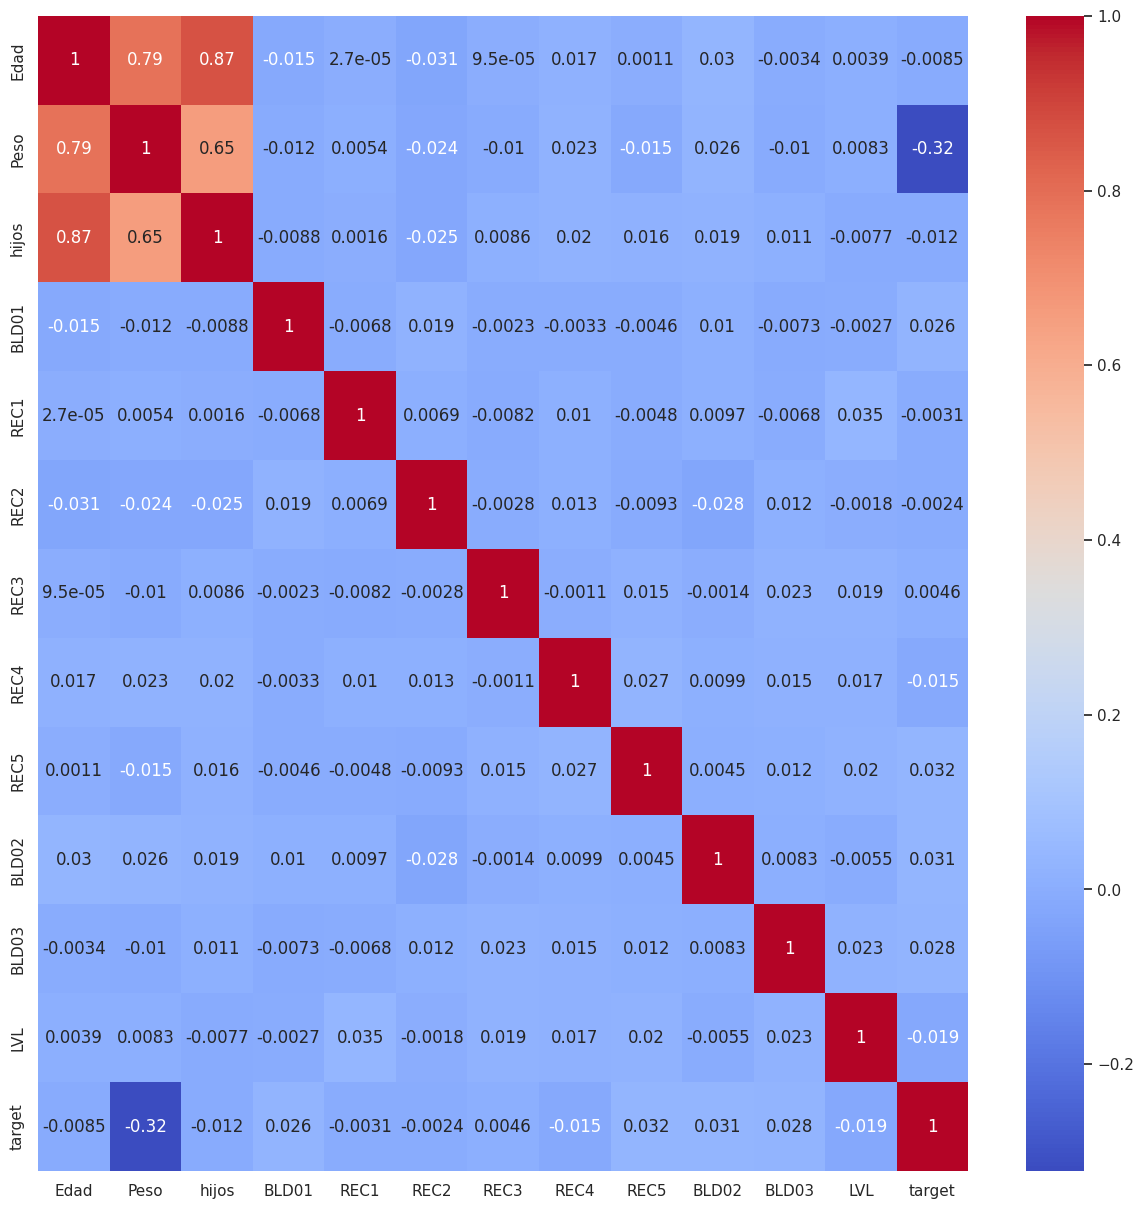

In [122]:
df_numericas = df.select_dtypes(include='number')
corr = df_numericas.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Podemos ver que las variables `Edad`, `Peso` e `Hijos` se encuentran fuertemente correlacionadas. Entre el resto de variables predictoras no se aprecia ninguna correlacion relevante.

Tambien la variable que mas correlacion tiene con `target` es `Peso`.

### c) Analisis de la variable target

In [123]:
total = len(df)
infectados = (df['target'] == 1).sum()
no_infectados = (df['target'] == 0).sum()

pct_infectados = infectados / total * 100
pct_no_infectados = no_infectados / total * 100

print(f"{infectados} pacientes sobre un total de {total} pacientes se encuentran infectados por el virus. Corresponde a un {pct_infectados:.2f}% de infectados.")
print(f"{no_infectados} pacientes sobre un total de {total} pacientes no se encuentran infectados por el virus. Corresponde a un {pct_no_infectados:.2f}% de pacientes sanos.")

1707 pacientes sobre un total de 4200 pacientes se encuentran infectados por el virus. Corresponde a un 40.64% de infectados.
2493 pacientes sobre un total de 4200 pacientes no se encuentran infectados por el virus. Corresponde a un 59.36% de pacientes sanos.


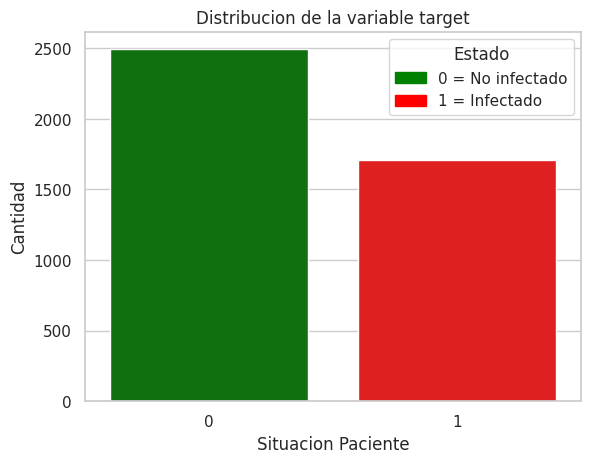

In [124]:
sns.countplot(x='target', hue='target', data=df, palette=['green', 'red'], legend=False)
plt.xlabel('Situacion Paciente')
plt.ylabel('Cantidad')
plt.title('Distribucion de la variable target')

patch_no_infectado = mpatches.Patch(color='green', label='0 = No infectado')
patch_infectado = mpatches.Patch(color='red', label='1 = Infectado')

plt.legend(handles=[patch_no_infectado, patch_infectado], title='Estado')

plt.show()

Hay un leve desbalance hacia el valor negativo en la clase `target`. Si no se toman medidas, el modelo tenderá a predecir más veces la clase que tiene más ejemplos (en este caso, que el paciente no posee el virus).

Considerando que el objetivo es **minimizar los falsos positivos**, inicialmente decidimos no realizar ninguna modificación, ya que preferimos que ante casos ambiguos el modelo se incline por una predicción negativa en lugar de una positiva.

Posteriormente probaremos si realizar un undersampling mejoraría o no los resultados.

## 2) Analisis por colunma

A continuacion, vamos a realizar un analisis más en profundidad sobre cada una de las posibles variables predictoras para entender su distribucion y relación con la variable target.

### a) Analisis Columna **Edad**

#### Conteo de Edades Limites

Comenzamos evaluando las edades muy bajas o altas para empezar a detectar valores outliers.

In [125]:
conteo_edades = df['Edad'].value_counts().sort_index()

conteo_filtrado = conteo_edades[(conteo_edades.index < 5) | (conteo_edades.index > 70)]

print(conteo_filtrado)

Edad
0.0     47
1.0     57
2.0     52
3.0     48
4.0     60
71.0    47
72.0    62
73.0    50
74.0    50
75.0    41
76.0    58
77.0    44
78.0    39
79.0    52
Name: count, dtype: int64


No se observan edades anómalas que puedan actuar como outliers.

#### Distribucion de Edades

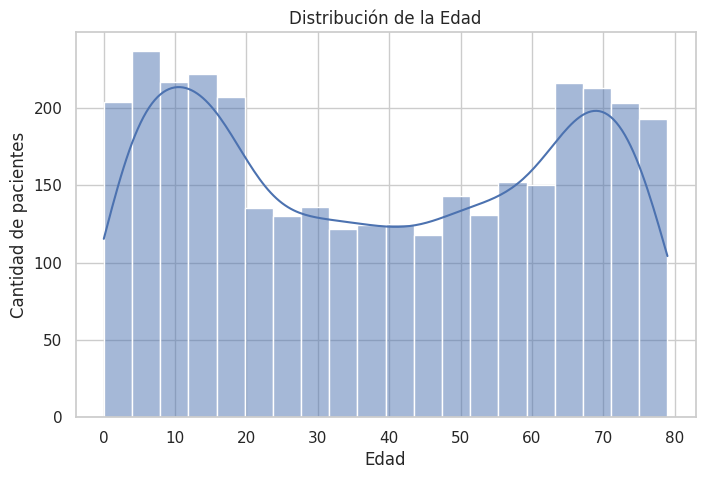

In [126]:
plt.figure(figsize=(8,5))
sns.histplot(df['Edad'], bins=20, kde=True)
plt.title('Distribución de la Edad')
plt.xlabel('Edad')
plt.ylabel('Cantidad de pacientes')
plt.show()

Podemos ver que la variable `Edad` no tiene valores erroneos, ya que los valores posibles se encuentran entre 0 y 79 años.

Tambien podemos ver que hay mas registros de personas entre 0 y 20 años y entre 60 y 79 años aproximadamente.

En este histograma podemos distinguir 3 grupos etarios.

*   "Niños/Jovenes" entre 0 y 20 años
*   "Adultos" entre 20 y 60 años
*  "Adultos mayores" entre 60 y 79 años


#### Boxplot general

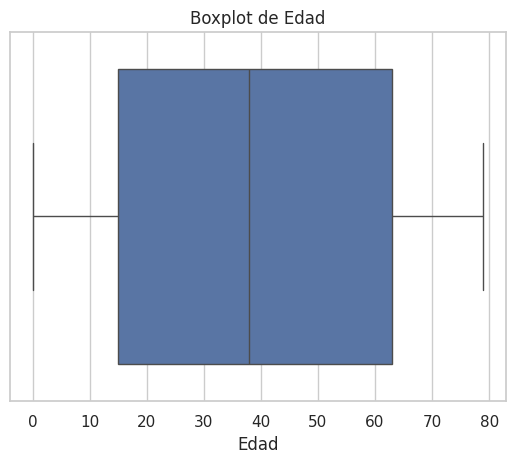

In [127]:
sns.boxplot(x=df['Edad'])
plt.title('Boxplot de Edad')
plt.xlabel('Edad')
plt.show()

Podemos ver la la variable `Edad` no tiene valores outliers

#### Boxplot por clase

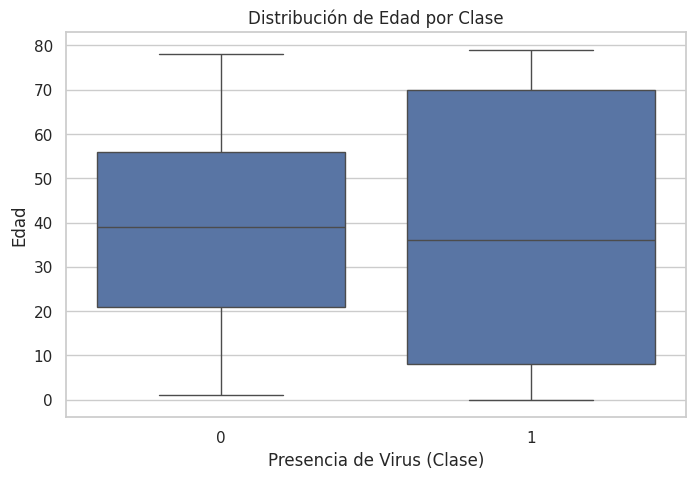

In [128]:
plt.figure(figsize=(8,5))
sns.boxplot(x='target', y='Edad', data=df)
plt.title('Distribución de Edad por Clase')
plt.xlabel('Presencia de Virus (Clase)')
plt.ylabel('Edad')
plt.show()

#### Distribucion de Edades por clase

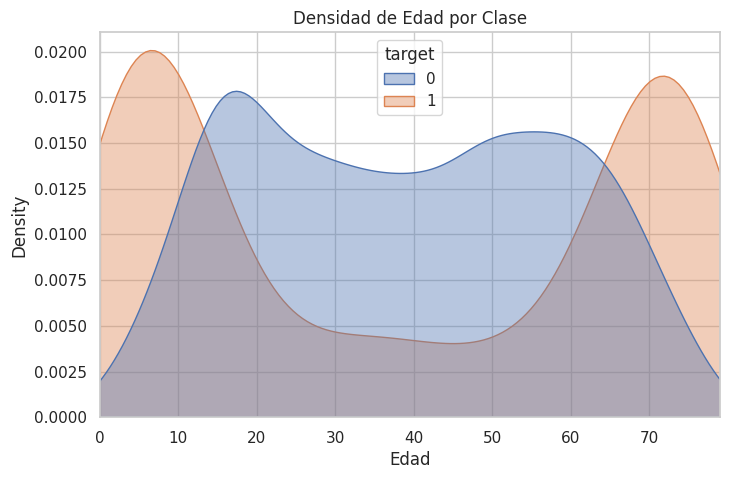

In [129]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='Edad', hue='target', fill=True, common_norm=False, alpha=0.4)
plt.title('Densidad de Edad por Clase')
plt.xlim(0, df['Edad'].max())
plt.show()

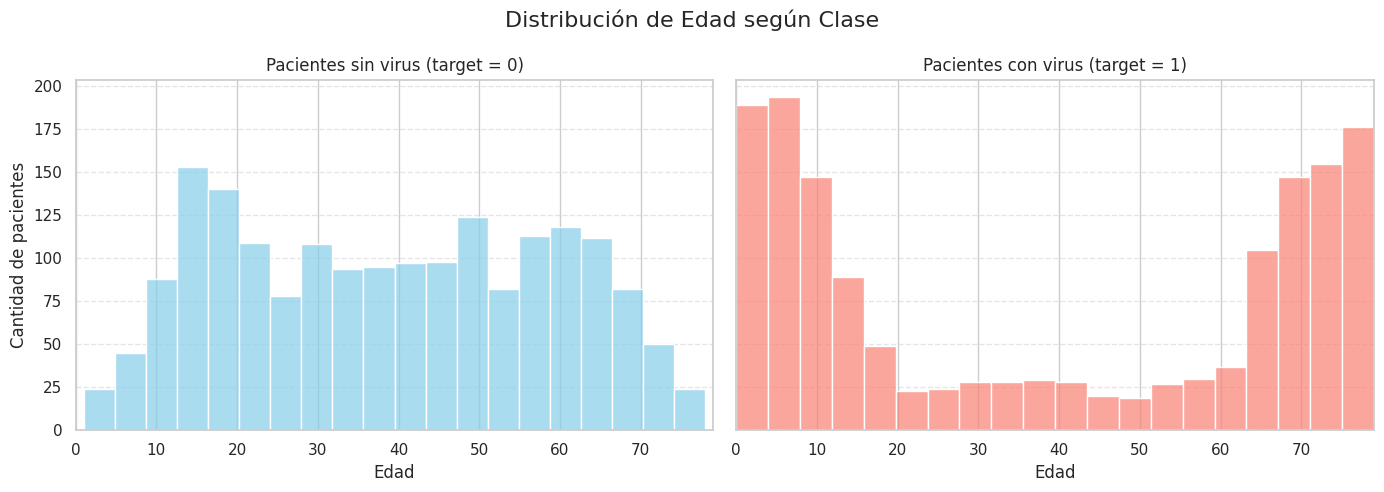

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.histplot(data=df[df['target'] == 0], x='Edad', bins=20, color='skyblue', alpha=0.7, ax=axes[0])
axes[0].set_title('Pacientes sin virus (target = 0)')
axes[0].set_xlabel('Edad')
axes[0].set_ylabel('Cantidad de pacientes')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].set_xlim(0, df['Edad'].max())

sns.histplot(data=df[df['target'] == 1], x='Edad', bins=20, color='salmon', alpha=0.7, ax=axes[1])
axes[1].set_title('Pacientes con virus (target = 1)')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].set_xlim(0, df['Edad'].max())

plt.suptitle('Distribución de Edad según Clase', fontsize=16)
plt.tight_layout()
plt.show()

En estos ultimos gráficos podemos ver que las personas ente 0 y 18 años y mayores de 62 aproximadamente son mas propensos a estar infectados por el virus. Por otro lado, hay muy pocas personas adultas entre 18 y 62 años infectadas.

Se podria teorizar que los pacientes de riesgo para este virus son personas jovenes (niños mayormente) y personas ancianas.

### b) Analisis Columna **Genero**

#### Conteo de cada genero

Vemos la cantidad de apariciones de cada categoria de Genero

In [131]:
conteo_genero = df['Genero'].value_counts()
print(conteo_genero)

Genero
Masculino    2159
Femenino      320
Otro           39
Name: count, dtype: int64


Podemos separar a las personas en 3 posibles categorías en cuanto al genero.

#### Countplot general

Con este grafico de barras podemos ver cuantos pacientes hay en cada género

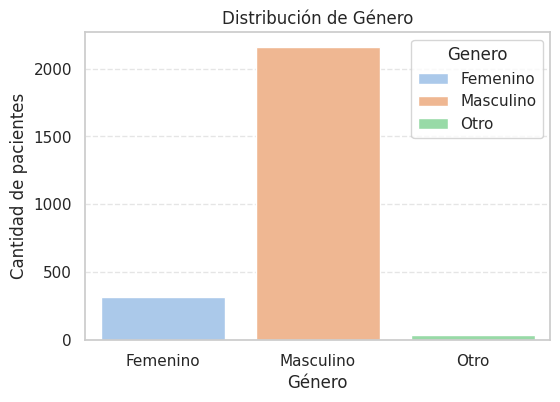

In [132]:
plt.figure(figsize=(6,4))
sns.countplot(x='Genero', hue='Genero', data=df, palette='pastel')
plt.title('Distribución de Género')
plt.xlabel('Género')
plt.ylabel('Cantidad de pacientes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### Countplot de Género por clase (target)

Realizamos el mismo countplot anterior, pero esta vez segmentando por la variable target para ver si alguna clase de género tiene mayor proporcion de casos positivos/negativos

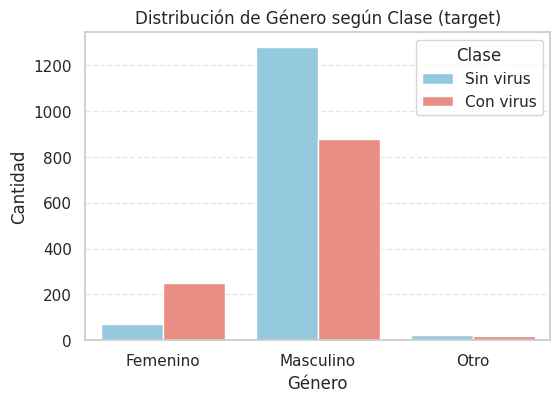

In [133]:
plt.figure(figsize=(6,4))
sns.countplot(x='Genero', hue='target', data=df, palette=['skyblue','salmon'])
plt.title('Distribución de Género según Clase (target)')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.legend(title='Clase', labels=['Sin virus','Con virus'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

A priori no vemos una relacion directa entre el genero y la infeccion, en todas las categorias hay personas afectadas y no afectadas pero no observamos ninguna tendencia por ahora.

### c) Analisis Columna **Peso**

#### Estadísticas de Peso

Utilizamos describe() para conocer el conteo, media, desviacion, percentiles, etc.

In [134]:
estadisticas_peso = df['Peso'].describe()
print(estadisticas_peso)

count    4200.000000
mean       74.011575
std        25.792979
min         8.934178
25%        59.380536
50%        81.736000
75%        92.850926
max       128.850297
Name: Peso, dtype: float64


#### Boxplot general

Mediante este grafico podemos detectar los posibles outliers.

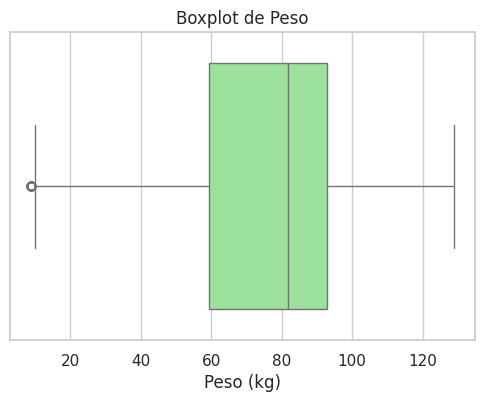

In [135]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Peso'], color='lightgreen')
plt.title('Boxplot de Peso')
plt.xlabel('Peso (kg)')
plt.show()

Vemos que si partimos de los datos ordenados, podemos determinar que el primer 25% presenta una mayor cantidad de registros, los cuales tienen un peso entre 15 y 60 aproximadamente.

In [136]:
Q1 = df['Peso'].quantile(0.25)
Q3 = df['Peso'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Peso'] < limite_inferior) | (df['Peso'] > limite_superior)]

print(f'Cantidad de outliers en Peso: {len(outliers)}')

Cantidad de outliers en Peso: 47


Podemos ver que hay 47 registros cuyos valores no son proximos al resto de los datos, los cuales determinamos como outliers.

#### Boxplot de Peso por Target

Realizamos el boxplot segmentado por la variable target para visualizar si las distribuciones de peso difieren entre casos positivos y negativos

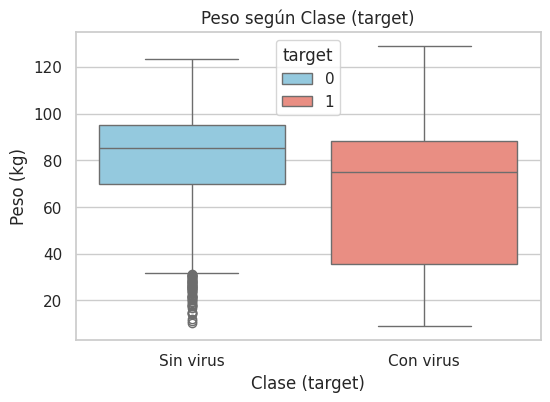

In [137]:
plt.figure(figsize=(6,4))
sns.boxplot(x='target', hue='target', y='Peso', data=df, palette=['skyblue','salmon'])
plt.title('Peso según Clase (target)')
plt.xlabel('Clase (target)')
plt.ylabel('Peso (kg)')
plt.xticks([0,1], ['Sin virus','Con virus'])
plt.show()

#### Curva KDE de peso por Target

Graficamos la KDE para realizar comparacion de densidades

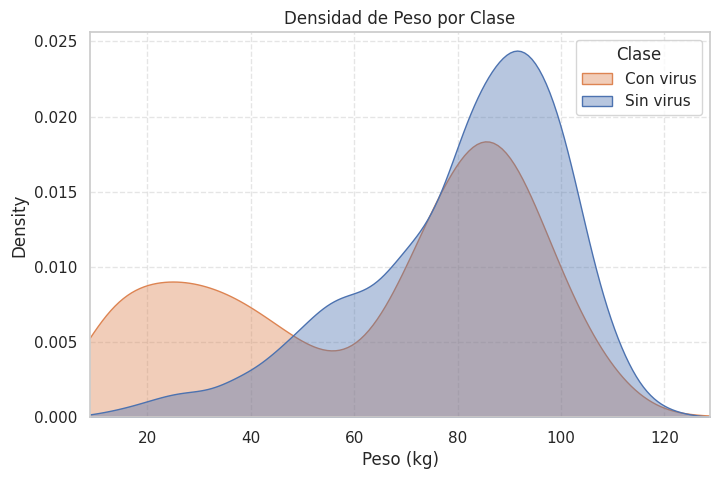

In [138]:

plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='Peso', hue='target', fill=True, common_norm=False, alpha=0.4)
plt.title('Densidad de Peso por Clase')
plt.xlabel('Peso (kg)')
plt.xlim(df['Peso'].min(), df['Peso'].max())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Clase', labels=['Con virus','Sin virus'])
plt.show()

#### Histogramas de Peso por Target

Realizamos histogramas lado a lado para cada clase, facilitando la comparación visual

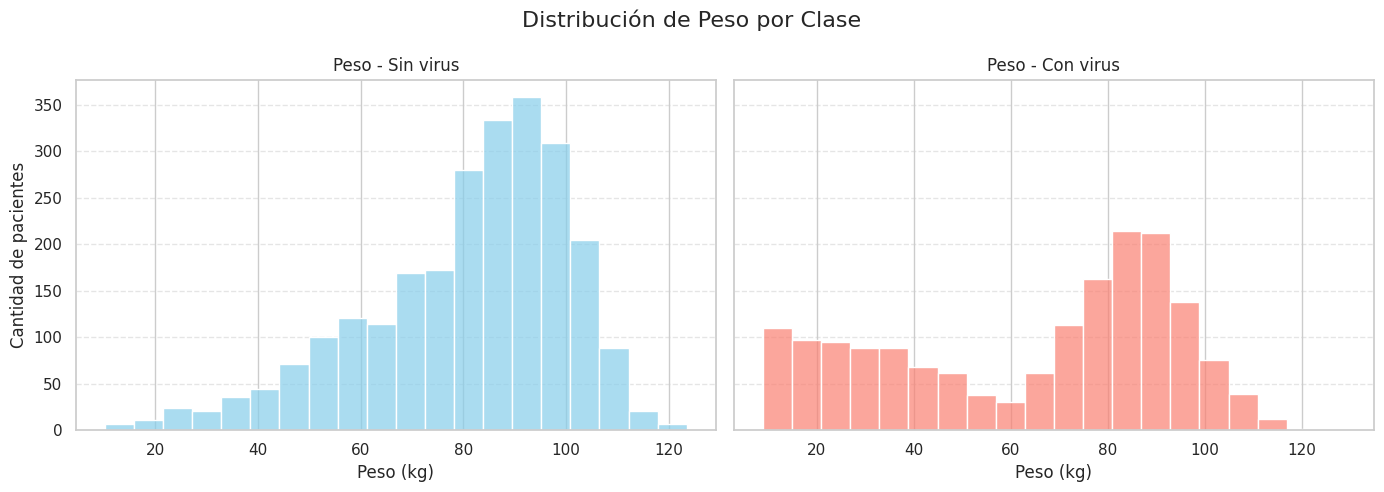

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

sns.histplot(data=df[df['target'] == 0], x='Peso', bins=20, color='skyblue', alpha=0.7, ax=axes[0])
axes[0].set_title('Peso - Sin virus')
axes[0].set_xlabel('Peso (kg)')
axes[0].set_ylabel('Cantidad de pacientes')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

sns.histplot(data=df[df['target'] == 1], x='Peso', bins=20, color='salmon', alpha=0.7, ax=axes[1])
axes[1].set_title('Peso - Con virus')
axes[1].set_xlabel('Peso (kg)')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Distribución de Peso por Clase', fontsize=16)
plt.tight_layout()
plt.show()

A partir de los últimos gráficos, se observa que las personas infectadas presentan un peso que oscila aproximadamente entre 15 y 50 kg, y entre 65 y 100 kg.

Las personas no infectadas oscilan entre 50 y 110kg.

### d) Analisis Columna **Laboral**

#### Conteo de situacion laboral

In [140]:
conteo_laboral = df['Laboral'].value_counts()
print(conteo_laboral)

Laboral
Inactivo      2088
Activo        1790
No_declara     322
Name: count, dtype: int64


#### Countplot general

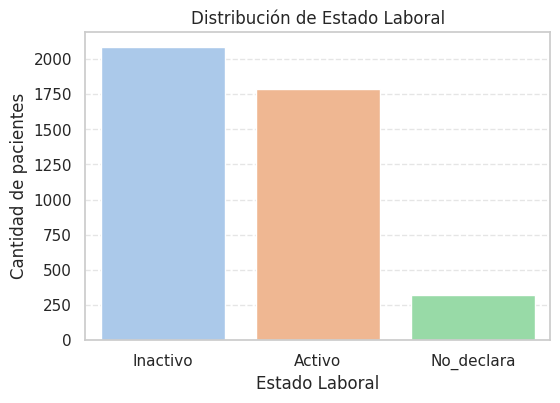

In [141]:
plt.figure(figsize=(6,4))
sns.countplot(x='Laboral', hue='Laboral', data=df, palette='pastel')
plt.title('Distribución de Estado Laboral')
plt.xlabel('Estado Laboral')
plt.ylabel('Cantidad de pacientes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### Countplot de Laboral por clase (target)

Podemos observar si el estado laboral ("Activo", "Inactivo" y "No_Declara") se asocia de algun modo con la presencia de virus

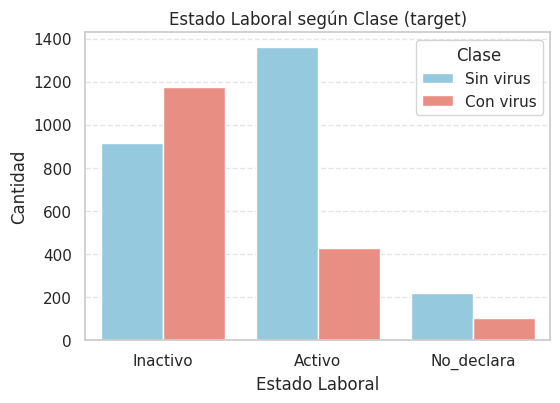

In [142]:
plt.figure(figsize=(6,4))
sns.countplot(x='Laboral', hue='target', data=df, palette=['skyblue','salmon'])
plt.title('Estado Laboral según Clase (target)')
plt.xlabel('Estado Laboral')
plt.ylabel('Cantidad')
plt.legend(title='Clase', labels=['Sin virus','Con virus'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Aplicamos el mismo análisis realizado sobre la columna Género a la variable Laboral, dado que ambas son categóricas.

Este ultimo grafico parece mostrar que las personas con estado laboral activo son menos propensas a ser infectadas por el virus.

### e) Analisis Columna **Hijos**

#### Bloxplot general

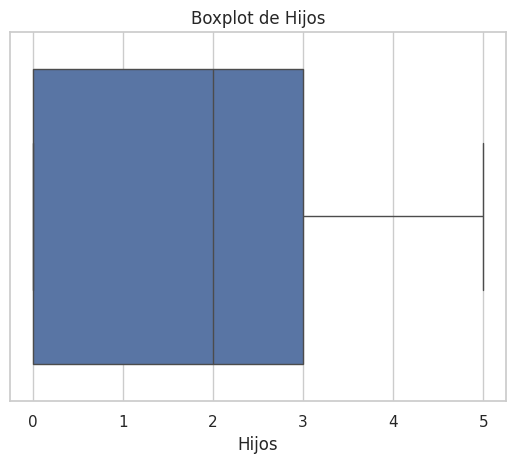

In [143]:
sns.boxplot(x=df['hijos'])
plt.title('Boxplot de Hijos')
plt.xlabel('Hijos')
plt.show()

#### Conteo de personas por cantidad de hijos

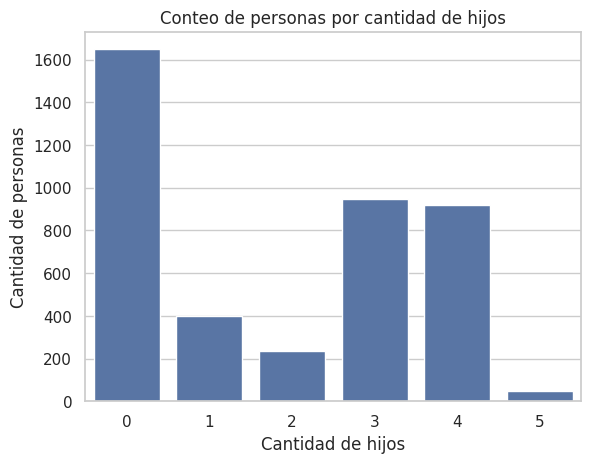

In [144]:
sns.countplot(x='hijos', data=df)
plt.title('Conteo de personas por cantidad de hijos')
plt.xlabel('Cantidad de hijos')
plt.ylabel('Cantidad de personas')
plt.show()

La variable hijos no presenta ni outliers ni valores atípicos o erroneos, por lo cual no haremos imputaciones. El rango de la variable va desde 0 a 5 hijos.

### f) Analisis Columna **BLD01**

#### Boxplot para BLD01

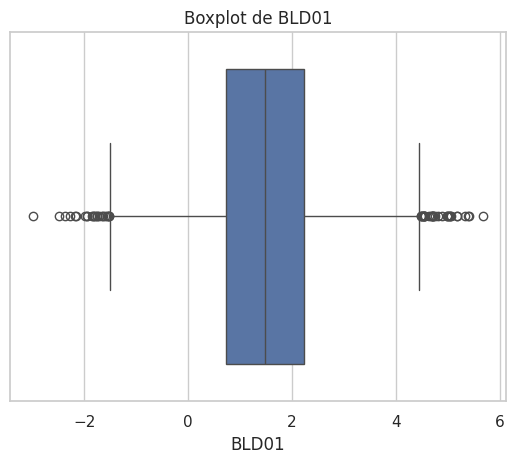

In [145]:
sns.boxplot(x=df['BLD01'])
plt.title('Boxplot de BLD01')
plt.xlabel('BLD01')
plt.show()

Podemos ver que esta variable presenta valores outliers

#### Cantidad de Outliers

In [146]:
Q1 = df['BLD01'].quantile(0.25)
Q3 = df['BLD01'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['BLD01'] < limite_inferior) | (df['BLD01'] > limite_superior)]

print(f'Cantidad de outliers en BLD01: {len(outliers)}')

Cantidad de outliers en BLD01: 56


#### Boxplot por clase

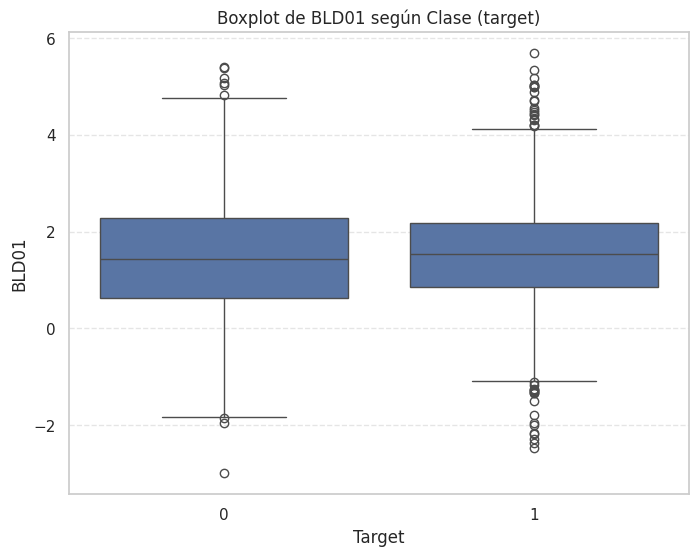

In [147]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='target', y='BLD01')
plt.title('Boxplot de BLD01 según Clase (target)')
plt.xlabel('Target')
plt.ylabel('BLD01')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Podemos ver que ambos boxplot son similares diferenciando por la variable target

#### Histograma

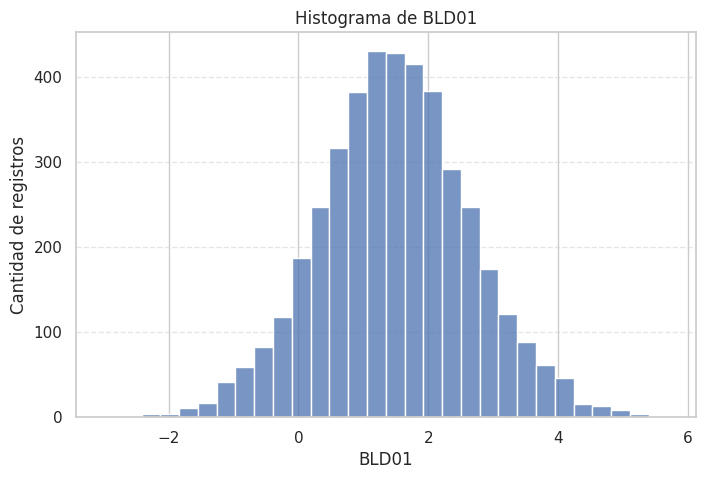

In [148]:
plt.figure(figsize=(8,5))
sns.histplot(data=df[df['BLD01'] < 6], x='BLD01', bins=30, kde=False)
plt.title('Histograma de BLD01')
plt.xlabel('BLD01')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Observamos que la media de la variable es alrededor de 2 y los valores definidos como outliers se encuentran por debajo de -1 y por encima de 4 aproximadamente.

#### Distribucion por clase

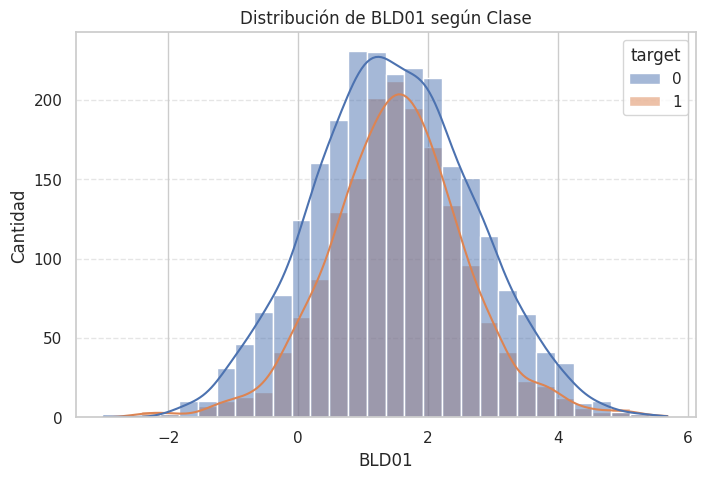

In [149]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='BLD01', hue='target', kde=True, bins=30, alpha=0.5)
plt.title('Distribución de BLD01 según Clase')
plt.xlabel('BLD01')
plt.ylabel('Cantidad')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Existen diferencias leves en la distribucion de `BLD01` según el `target`, lo cual podría ser útil como variable predictora, aunque no parecer ser un predictor fuertemente diferenciador por sí solo.

### g) Analisis Columna **REC1**

#### Boxplot para REC 1

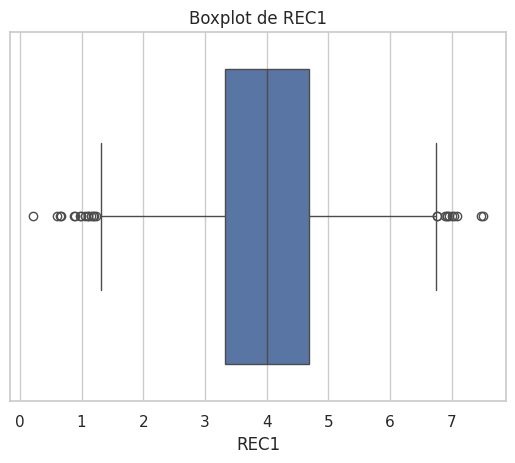

In [150]:
sns.boxplot(x=df['REC1'])
plt.title('Boxplot de REC1')
plt.xlabel('REC1')
plt.show()

#### Cantidad de Outliers

In [151]:
Q1 = df['REC1'].quantile(0.25)
Q3 = df['REC1'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['REC1'] < limite_inferior) | (df['REC1'] > limite_superior)]

print(f'Cantidad de outliers en REC1: {len(outliers)}')

Cantidad de outliers en REC1: 26


La variable `REC1` tiene algunos valores outiliers, los cuales vamos a imputar en caso de utilizar este feature

#### Histograma

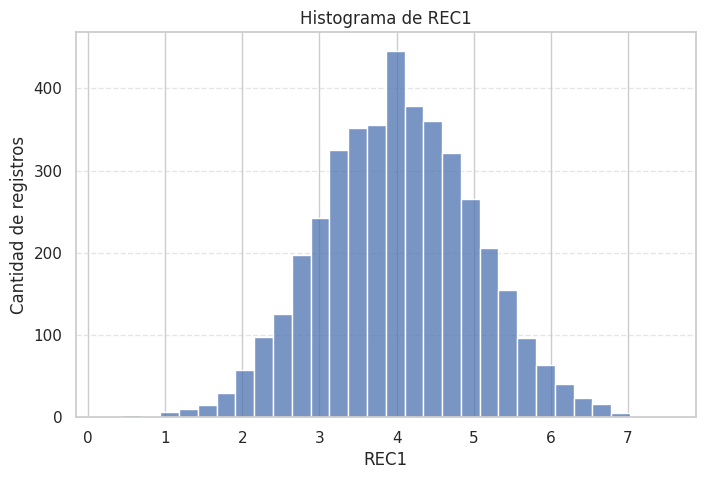

In [152]:
plt.figure(figsize=(8,5))
sns.histplot(data=df[df['REC1'] < 100], x='REC1', bins=30, kde=False)
plt.title('Histograma de REC1')
plt.xlabel('REC1')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Podemos ver que la media de la variable es alrededor de 4 y los valores definidos como outliers se encuentran por debajo de 1 y por encima de 7 aproximadamente.

### h) Analisis Columna **REC2**

#### Boxplot para REC2

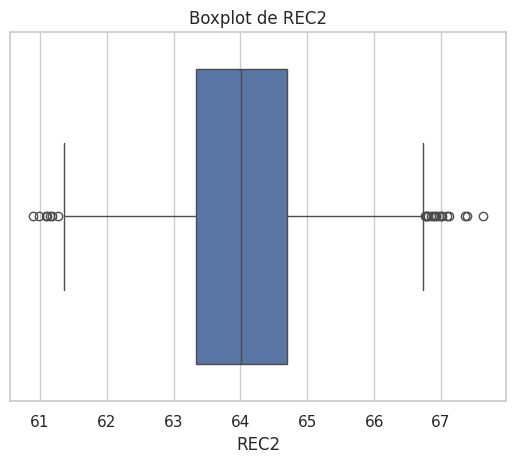

In [153]:
sns.boxplot(x=df['REC2'])
plt.title('Boxplot de REC2')
plt.xlabel('REC2')
plt.show()

#### Cantidad de Outliers

In [154]:
Q1 = df['REC2'].quantile(0.25)
Q3 = df['REC2'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['REC2'] < limite_inferior) | (df['REC2'] > limite_superior)]

print(f'Cantidad de outliers en REC2: {len(outliers)}')

Cantidad de outliers en REC2: 23


La variable `REC2` tiene algunos valores outiliers, los cuales vamos a imputar en caso de utilizar este feature en el modelo.

#### Histograma

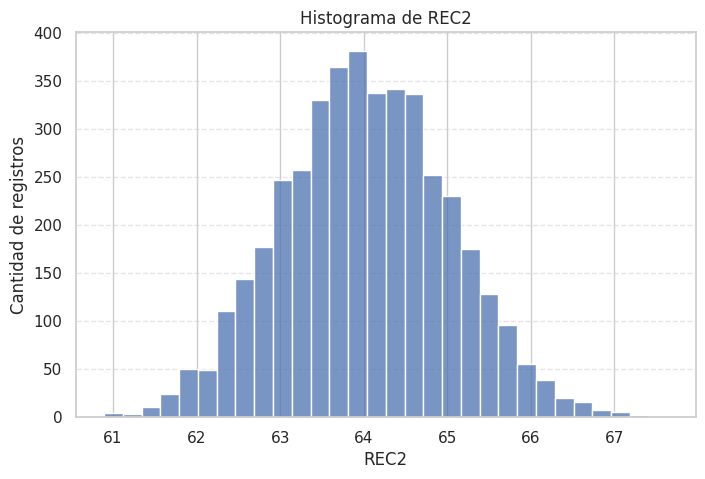

In [155]:
plt.figure(figsize=(8,5))
sns.histplot(data=df[df['REC2'] < 100], x='REC2', bins=30, kde=False)
plt.title('Histograma de REC2')
plt.xlabel('REC2')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Podemos ver que la media de la variable es alrededor de 64 y los valores definidos como outliers se encuentran por debajo de 61 y por encima de 67 aproximadamente.

### i) Analisis Columna **REC3**

#### Boxplot para REC3

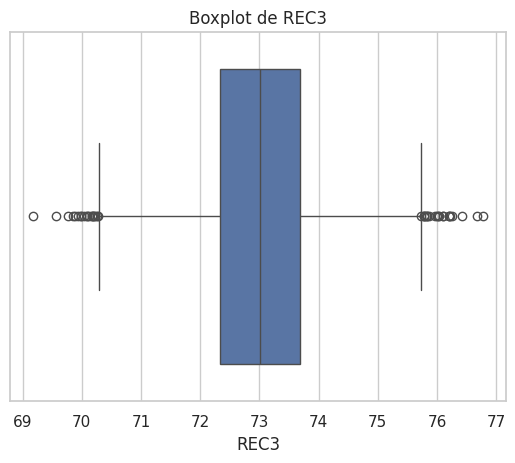

In [156]:
sns.boxplot(x=df['REC3'])
plt.title('Boxplot de REC3')
plt.xlabel('REC3')
plt.show()

#### Cantidad de Outliers

In [157]:
Q1 = df['REC3'].quantile(0.25)
Q3 = df['REC3'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['REC3'] < limite_inferior) | (df['REC3'] > limite_superior)]

print(f'Cantidad de outliers en REC3: {len(outliers)}')

Cantidad de outliers en REC3: 40


La variable `REC3` tiene algunos valores outiliers, los cuales vamos a imputar en caso de utilizar este feature en el modelo.

#### Histograma

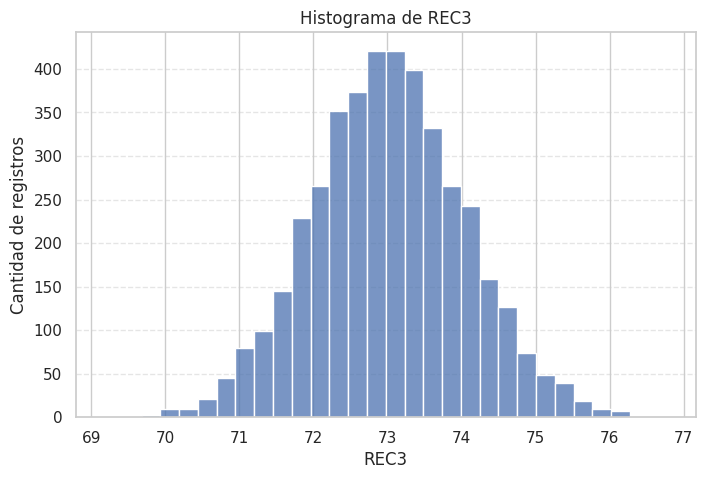

In [158]:
plt.figure(figsize=(8,5))
sns.histplot(data=df[df['REC3'] < 100], x='REC3', bins=30, kde=False)
plt.title('Histograma de REC3')
plt.xlabel('REC3')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Podemos ver que la media de la variable es alrededor de 73 y los valores definidos como outliers se encuentran por debajo de 70 y por encima de 76 aproximadamente.

### j) Analisis Columna **REC4**

#### Bloxplot para REC4

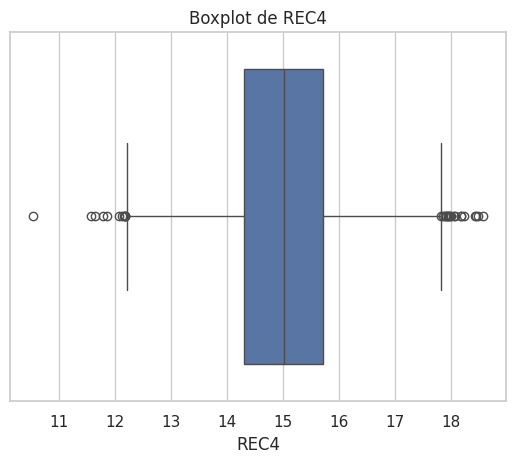

In [159]:
sns.boxplot(x=df['REC4'])
plt.title('Boxplot de REC4')
plt.xlabel('REC4')
plt.show()

#### Cantidad de Outliers

In [160]:
Q1 = df['REC4'].quantile(0.25)
Q3 = df['REC4'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['REC4'] < limite_inferior) | (df['REC4'] > limite_superior)]

print(f'Cantidad de outliers en REC4: {len(outliers)}')

Cantidad de outliers en REC4: 30


La variable `REC4` tiene algunos valores outiliers, los cuales vamos a imputar en caso de utilizar este feature en el modelo.

#### Histograma

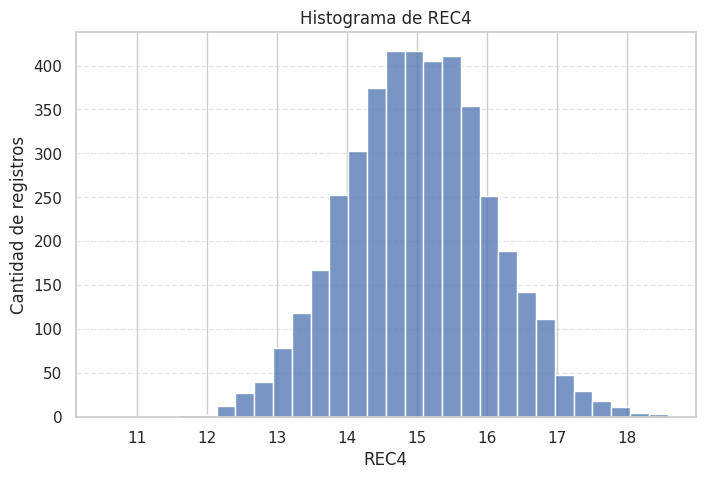

In [161]:
plt.figure(figsize=(8,5))
sns.histplot(data=df[df['REC4'] < 20], x='REC4', bins=30, kde=False)
plt.title('Histograma de REC4')
plt.xlabel('REC4')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Podemos ver que la media de la variable es alrededor de 15 y los valores definidos como outliers se encuentran por debajo de 12 y por encima de 18 aproximadamente.

### k) Analisis Columna **REC5**

#### Bloxplot para REC5

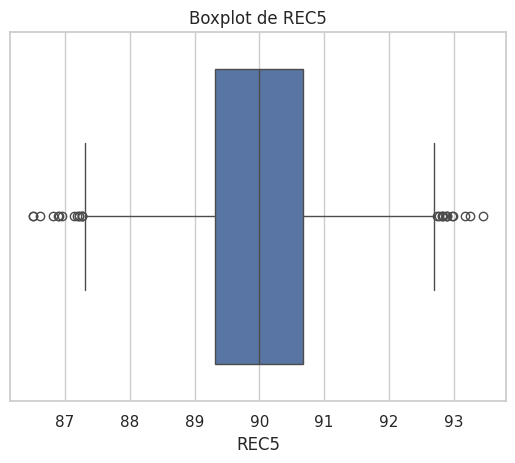

In [162]:
sns.boxplot(x=df['REC5'])
plt.title('Boxplot de REC5')
plt.xlabel('REC5')
plt.show()

#### Cantidad de Outliers

In [163]:
Q1 = df['REC5'].quantile(0.25)
Q3 = df['REC5'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['REC5'] < limite_inferior) | (df['REC5'] > limite_superior)]

print(f'Cantidad de outliers en REC5: {len(outliers)}')

Cantidad de outliers en REC5: 27


La variable `REC5` tiene algunos valores outiliers, los cuales vamos a imputar en caso de utilizar este feature en el modelo.

#### Histograma

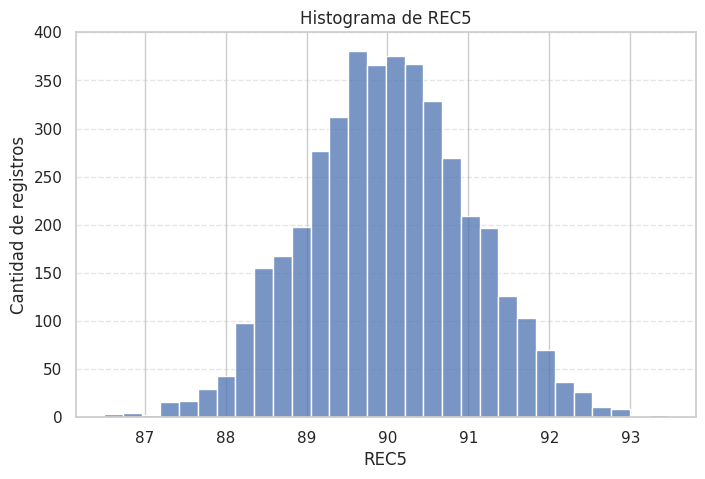

In [164]:
plt.figure(figsize=(8,5))
sns.histplot(data=df[df['REC5'] < 100], x='REC5', bins=30, kde=False)
plt.title('Histograma de REC5')
plt.xlabel('REC5')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Podemos ver que la media de la variable es alrededor de 90 y los valores definidos como outliers se encuentran por debajo de 87 y por encima de 93 aproximadamente.

### l) Analisis columna **BLD02**

#### Bloxplot para BLD02

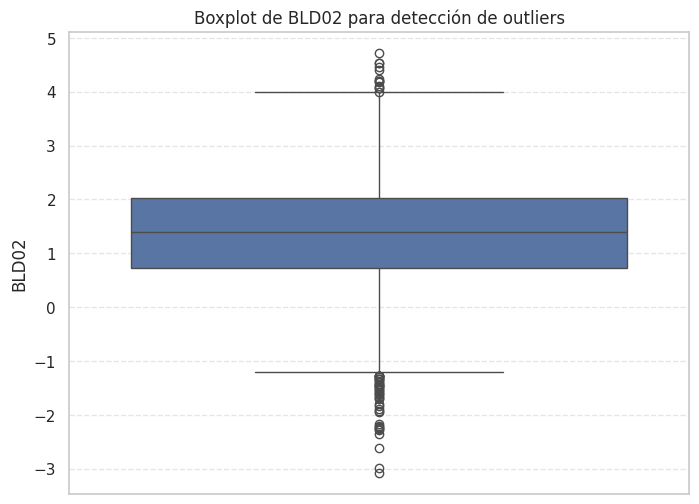

In [165]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, y='BLD02')
plt.title('Boxplot de BLD02 para detección de outliers')
plt.ylabel('BLD02')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### Cantidad de Outliers

In [166]:
Q1 = df['BLD02'].quantile(0.25)
Q3 = df['BLD02'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['BLD02'] < limite_inferior) | (df['BLD02'] > limite_superior)]

print(f'Cantidad de outliers en BLD02: {len(outliers)}')

Cantidad de outliers en BLD02: 55


La variable `BLD02` tiene algunos valores outiliers, los cuales vamos a imputar en caso de utilizar este feature en el modelo.

#### Boxplot por clase (target)

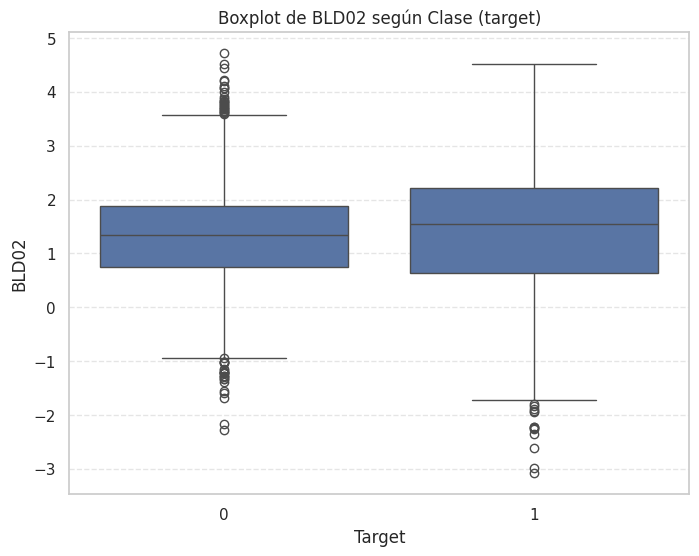

In [167]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='target', y='BLD02')
plt.title('Boxplot de BLD02 según Clase (target)')
plt.xlabel('Target')
plt.ylabel('BLD02')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### Histograma

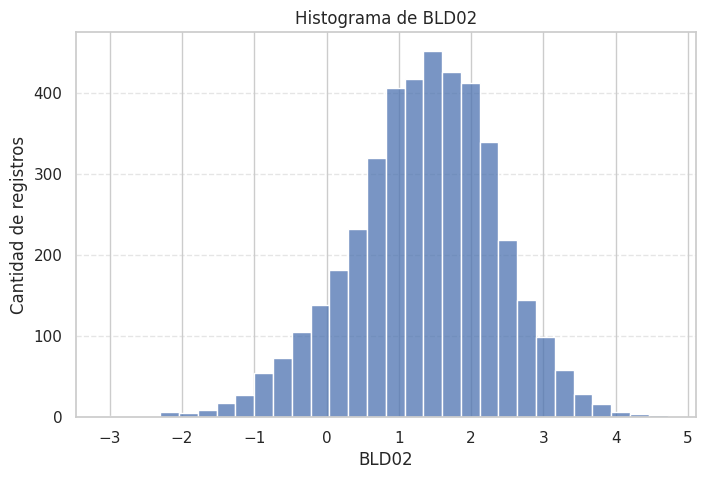

In [168]:
plt.figure(figsize=(8,5))
sns.histplot(data=df[df['BLD02'] < 100], x='BLD02', bins=30, kde=False)
plt.title('Histograma de BLD02')
plt.xlabel('BLD02')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### Distribucion por clase

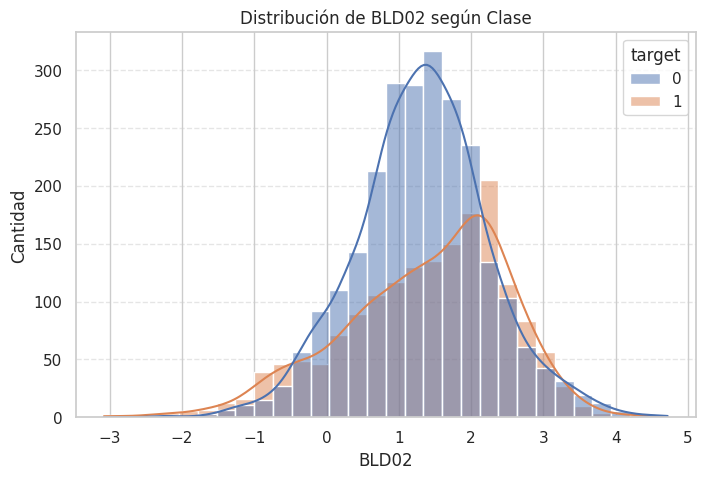

In [169]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='BLD02', hue='target', kde=True, bins=30, alpha=0.5)
plt.title('Distribución de BLD02 según Clase')
plt.xlabel('BLD02')
plt.ylabel('Cantidad')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Podemos ver que la media de la variable es alrededor de 1,5 y los valores definidos como outliers se encuentran por debajo de -1 y por encima de 3,5 aproximadamente.

### m) Analisis columna **BLD03**

#### Boxplot para BLD03

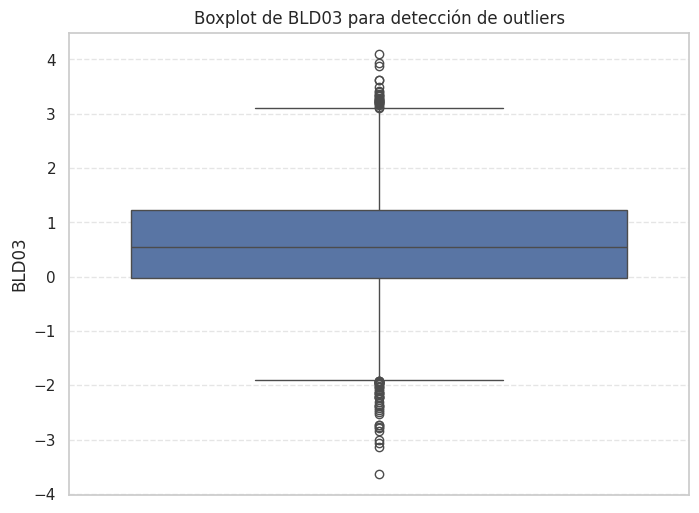

In [170]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, y='BLD03')
plt.title('Boxplot de BLD03 para detección de outliers')
plt.ylabel('BLD03')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### Cantidad de Outliers

In [171]:
Q1 = df['BLD03'].quantile(0.25)
Q3 = df['BLD03'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['BLD03'] < limite_inferior) | (df['BLD03'] > limite_superior)]

print(f'Cantidad de outliers en BLD03: {len(outliers)}')

Cantidad de outliers en BLD03: 68


La variable `BLD03` tiene algunos valores outiliers, los cuales vamos a imputar en caso de utilizar este feature en el modelo.

#### Boxplot por clase (target)

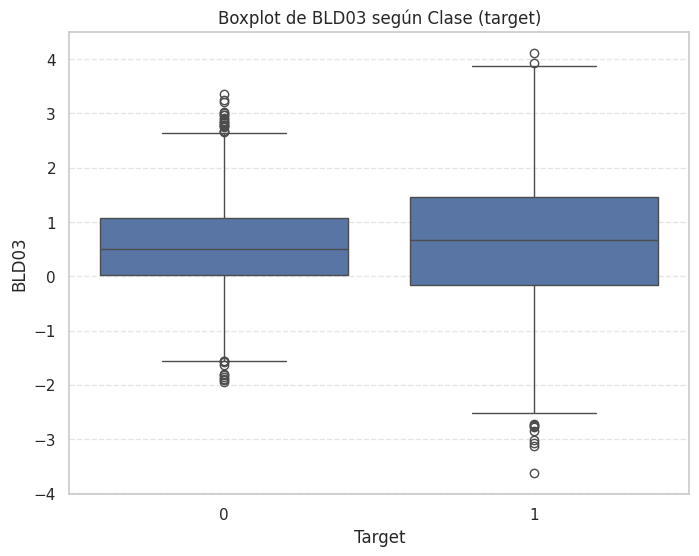

In [172]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='target', y='BLD03')
plt.title('Boxplot de BLD03 según Clase (target)')
plt.xlabel('Target')
plt.ylabel('BLD03')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### Histograma

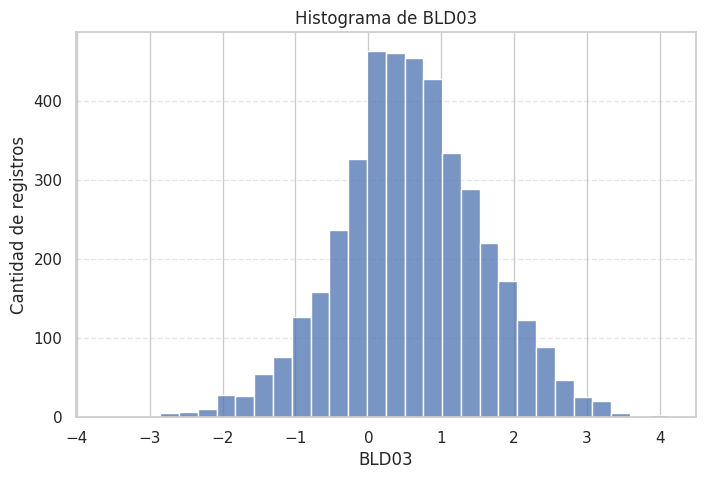

In [173]:
plt.figure(figsize=(8,5))
sns.histplot(data=df[df['BLD03'] < 100], x='BLD03', bins=30, kde=False)
plt.title('Histograma de BLD03')
plt.xlabel('BLD03')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### Distribucion por clase

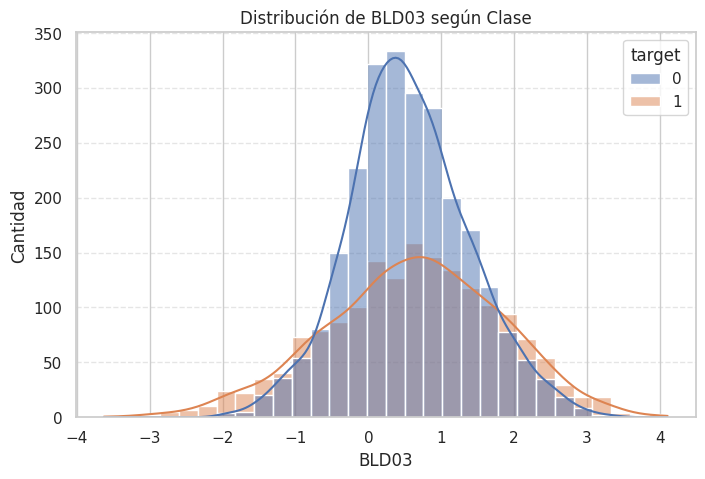

In [174]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='BLD03', hue='target', kde=True, bins=30, alpha=0.5)
plt.title('Distribución de BLD03 según Clase')
plt.xlabel('BLD03')
plt.ylabel('Cantidad')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Podemos ver que la media de la variable es alrededor de 0,5 y los valores definidos como outliers se encuentran por debajo de -1,5 y por encima de 2,5 aproximadamente.

### n) Analisis Columna **LVL**

#### Analisis valores por rangos

In [175]:
bins = [df['LVL'].min(), 0, 50, 100, 150, 200, 300, 500, 1000, 10_000, 100_000, 500_000, 999_999, 1_000_000]
conteo_rangos = {}

for i in range(len(bins)-1):
    low = bins[i]
    high = bins[i+1]
    if i == len(bins) - 2:
        mask = (df['LVL'] >= low) & (df['LVL'] <= high)
    else:
        mask = (df['LVL'] >= low) & (df['LVL'] < high)
    conteo_rangos[f'{low} - {high}'] = mask.sum()

print("Cantidad de registros por rango de LVL:")
for rango, count in conteo_rangos.items():
    print(f'{rango}: {count}')

Cantidad de registros por rango de LVL:
-15.793610073901403 - 0: 5
0 - 50: 327
50 - 100: 1094
100 - 150: 1397
150 - 200: 16
200 - 300: 0
300 - 500: 0
500 - 1000: 0
1000 - 10000: 0
10000 - 100000: 0
100000 - 500000: 0
500000 - 999999: 0
999999 - 1000000: 834


#### Boxplot (escala logaritmica)

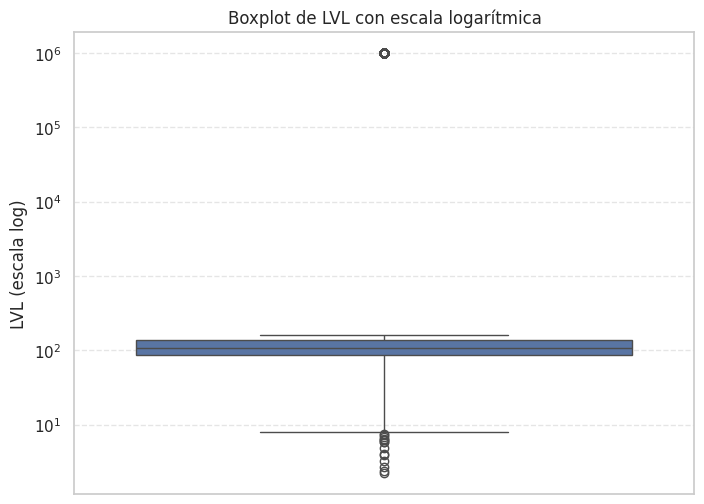

In [176]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, y='LVL')
plt.yscale('log')
plt.title('Boxplot de LVL con escala logarítmica')
plt.ylabel('LVL (escala log)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Se puede ver que esta columna cuenta con casi un tercio de valores outliers de un orden de 10^6 cuando la mayoria de valores se encuentran en el rango de 10^2, estos valores pueden ser valores erroneos.

#### Boxplot filtrado

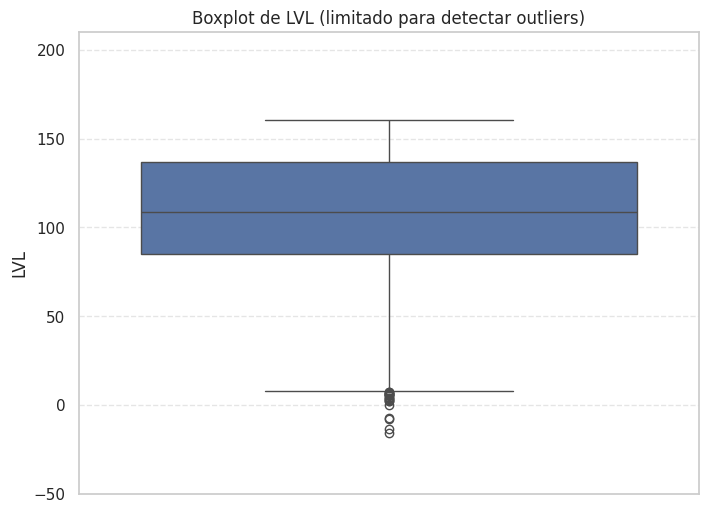

In [177]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='LVL')

plt.ylim(-50, 210)
plt.title('Boxplot de LVL (limitado para detectar outliers)')
plt.ylabel('LVL')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Ademas, la columa `LVL` cuenta con algunos valores outliers en el limite inferior.

#### Boxplot por clase

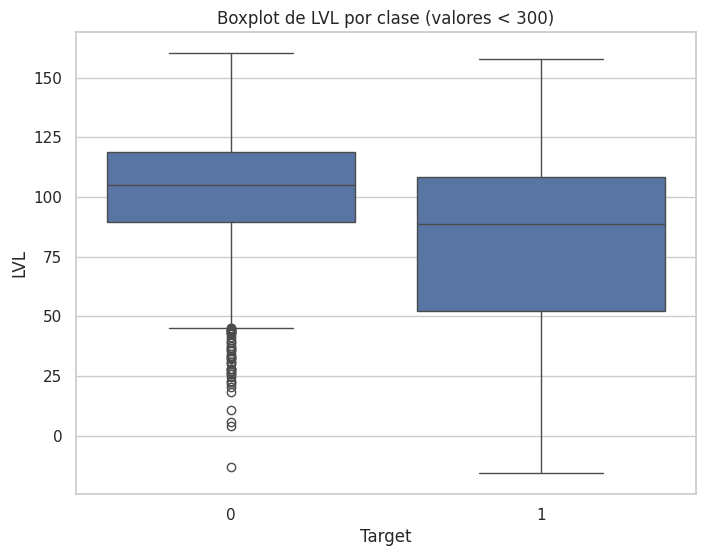

In [178]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[df['LVL'] < 300], x='target', y='LVL')
plt.title('Boxplot de LVL por clase (valores < 300)')
plt.xlabel('Target')
plt.ylabel('LVL')
plt.show()

La mayoria de los outliers del limite inferior corresponden a los pacientes sanos.

#### Histograma filtrado

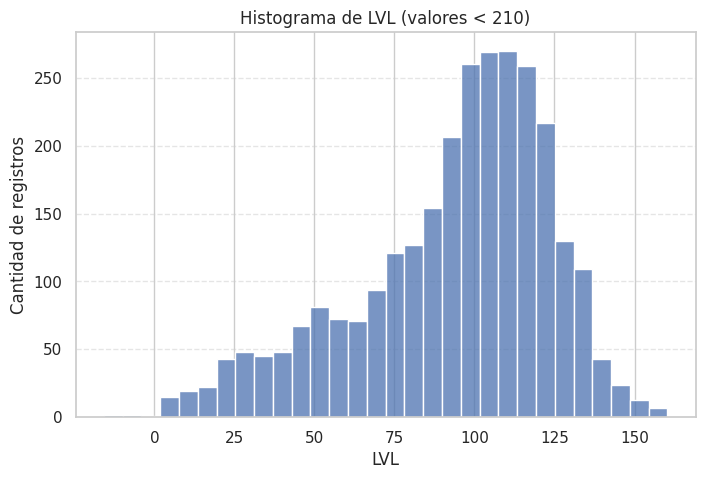

In [179]:
plt.figure(figsize=(8,5))
sns.histplot(data=df[df['LVL'] < 210], x='LVL', bins=30, kde=False)
plt.title('Histograma de LVL (valores < 210)')
plt.xlabel('LVL')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#### Histograma por clase

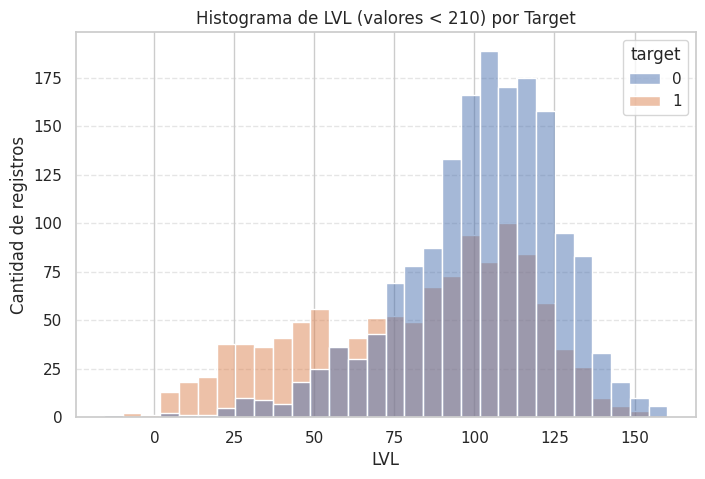

In [180]:
plt.figure(figsize=(8,5))

sns.histplot(
    data=df[df['LVL'] < 210],
    x='LVL',
    bins=30,
    hue='target',
    multiple='layer',
    alpha=0.5
)

plt.title('Histograma de LVL (valores < 210) por Target')
plt.xlabel('LVL')
plt.ylabel('Cantidad de registros')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Se puede apreciar que frente a valor bajos, hay mas casos de pacientes infectados. Por el contrario, en valores cercanos a la media hay mas casos de pacientes sanos

## 3) Separacion entre Test y Train

### Eliminacion de registros con LVL nulo

In [181]:
df = df.dropna(subset=["LVL"])

Probamos imputar los valores faltantes de la variable `LVL` utilizando distintas estrategias, pero en todos los casos, los resultados fueron inferiores a los obtenidos al eliminar directamente las filas con valores nulos en dicha columna. Por lo tanto, optamos por eliminar dichos registros.

Inicialmente, intentamos hacerlo incluyendo un paso dentro del Pipeline de **imbalanced learn** pero no logramos que funcione correctamente.
Al aplicar fit y transform sobre **X_train**, la cantidad de registros se reducía, y al realizar transform sobre **X_test**, también disminuía el número de filas. Sin embargo, esta reducción no se reflejaba en **y_test**, lo que provocaba un desajuste en la cantidad de filas entre las variables independientes y la variable objetivo, generando un error.

Para simplificar el pipeline, y ademas evitar borrar registros del set de datos de evaluacion al que no tenemos acceso, decidimos realizar esta transformacion previo al split. De esta manera, unicamente para la etapa de entrenamiento no se tendran en cuenta los registros sin un valor de `LVL`.

### Split del set de datos

Realizamos la separacion antes de realizar cualquier otra transformacion para evitar fuga de datos.

In [182]:
x_target = df.drop(['target'], axis=1)
y_target = df['target']

X_train, X_test, y_train, y_test = train_test_split(x_target, y_target, test_size=0.3, stratify = y_target, random_state=42)

Realizamos la separacion entre **train** y **test** sin filtrar ninguna columna extra. La seleccion de features la realizaremos adentro del pipeline.

## 4) Definicion del Pipeline

### Definicion de Clases

#### Imputador Simple

Imputamos los valores nulos de la columna `Edad` con la mediana.

Realizamos distintas pruebas con imputaciones por la **media**, la **mediana** y el valor **mas frecuente**, y el que mejor resultados nos dio fue la mediana.

In [183]:
class ColSimpleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.imputers = {}

    def fit(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            self.imputers[col] = X[col].median()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].fillna(self.imputers[col])
        return X

#### Imputador de Outliers

Imputamos los valores outliers con la media.

Probamos imputar con la mediana pero arrojo peores resultados. Definimos como outliers valores mas lejanos a 1,5 del rango intercuartílico.

In [184]:
class ColOutliersImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.medias_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for c in self.columns:
            Q1 = X[c].quantile(0.25)
            Q3 = X[c].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            mean_filtrada = X[(X[c] >= lower) & (X[c] <= upper)][c].mean()
            self.medias_[c] = mean_filtrada
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.columns:
            Q1 = X[c].quantile(0.25)
            Q3 = X[c].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            X[c] = np.where(
                (X[c] < lower) | (X[c] > upper),
                self.medias_[c],
                X[c]
            )
        return X

#### Scaler

Realizamos un escalado para las variables numéricas

In [185]:
class FullStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True, with_std=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.scaler = StandardScaler(with_mean=self.with_mean, with_std=self.with_std)

    def fit(self, X, y=None):
        self.columns = X.columns
        self.scaler.fit(X)
        return self

    def transform(self, X):
        X = X.copy()
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

#### Eliminar Features

Creamos un transformador customizado que nos permita filtrar o eliminar las features que no vamos a utilizar en el modelo.

In [186]:
class EliminarFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop, errors='ignore')

#### Modelo Clasificador

Después de probar distintas alternativas, el modelo que mostró mejores resultados fue el **Random Forest Classifier**, ajustado con los siguientes hiperparámetros.

In [187]:
rf_model = RandomForestClassifier(
    n_estimators=312,
    max_depth=26,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    criterion='entropy',
    random_state=42
)

### Definicion del Pipeline

#### Pipeline de Prepocesamiento

In [188]:
pipeline_preprocesamiento = Pipeline(steps=[
    ('eliminar_features', EliminarFeatures(columns_to_drop=['Genero', 'Peso', 'Laboral', 'REC5', 'REC2', 'REC3', 'REC4', 'LVL'])),
    ('imputar_edad', ColSimpleImputer(columns=['Edad'])),
    ('imputar_outliers', ColOutliersImputer(columns=['BLD01', 'REC1', 'BLD02', 'BLD03'])),
    ('escalar', FullStandardScaler())
])

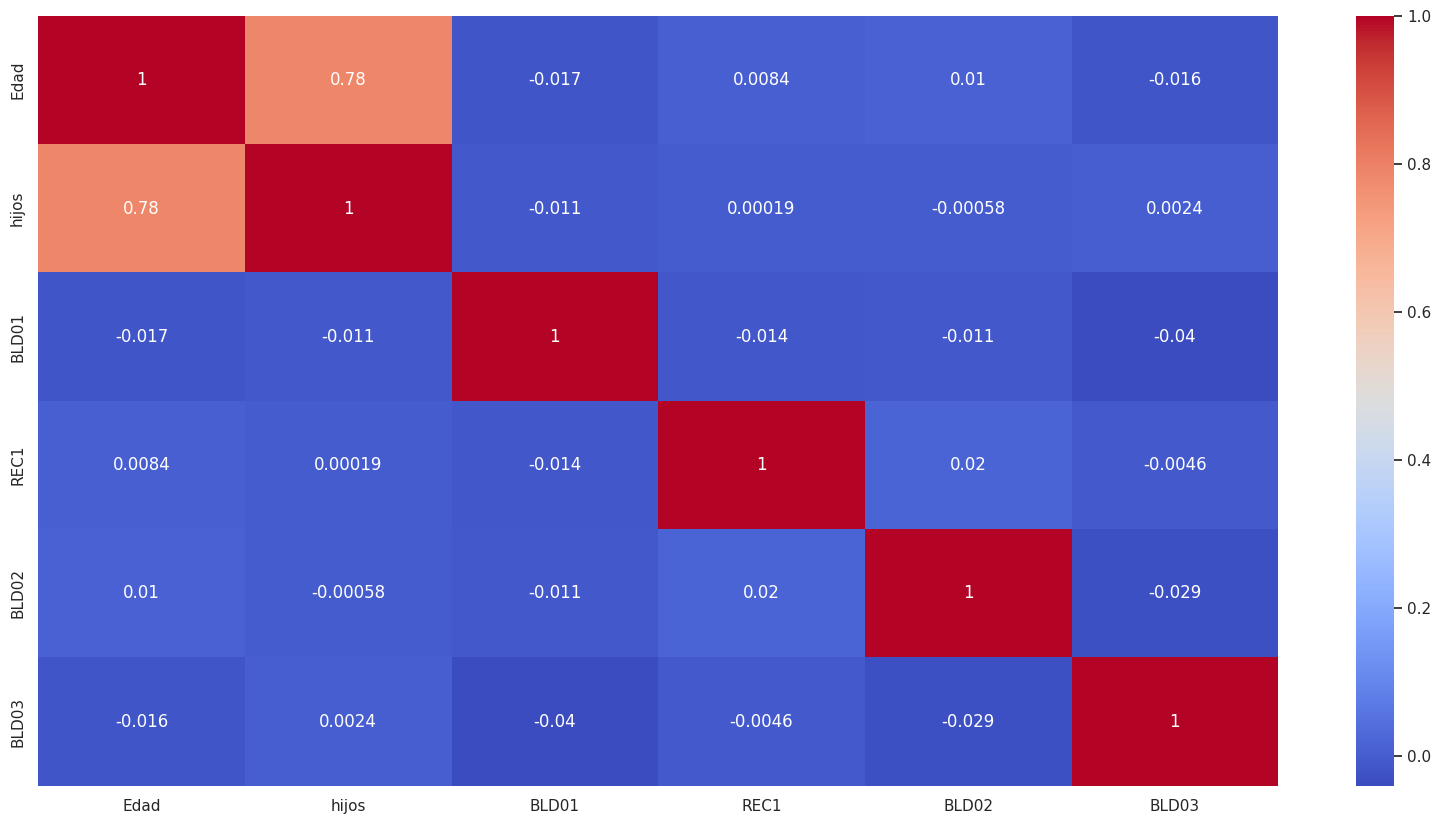

In [189]:
cols = ['Edad', 'hijos', 'BLD01', 'REC1', 'BLD02', 'BLD03']

pipeline_preprocesamiento.fit(X_train,y_train)
X_train_preprocesado = pipeline_preprocesamiento.transform(X_train)

X_train_preprocesado_df = pd.DataFrame(X_train_preprocesado, columns=cols, index=X_train.index)

plt.figure(figsize=(20,10))
sns.heatmap(X_train_preprocesado_df.corr(), annot=True, cmap='coolwarm')
plt.show()

Notamos que existe una correlación entre las variables `Edad` e `Hijos`, lo cual no es deseable entre variables predictoras. Por eso decidimos quedarnos solo con `Edad`. Sin embargo, al permutar distintas features y analizar los resultados obtenidos, verificamos que usar ambas variables juntas mejora el accuracy del modelo, a pesar de su correlación.

El modelo final utilizara los features `BLD01`, `BLD02`, `BLD03`, `Hijos`, `REC1` y `Edad`. En la parte 5: "Optimizacion", que se encuentra mas abajo en el archivo, explicamos los pasos que realizamos para llegar a estas columnas.

#### Pipeline clasificador

Construimos un pipeline que integra tanto las etapas de preprocesamiento de los datos como el modelo de clasificación seleccionado.

In [190]:
pipeline = Pipeline(steps=[
    ('prep', pipeline_preprocesamiento),
    ('clasificador', rf_model)
])

In [191]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 Pipeline(steps=[('eliminar_features',
                                  EliminarFeatures(columns_to_drop=['Genero',
                                                                    'Peso',
                                                                    'Laboral',
                                                                    'REC5',
                                                                    'REC2',
                                                                    'REC3',
                                                                    'REC4',
                                                                    'LVL'])),
                                 ('imputar_edad',
                                  ColSimpleImputer(columns=['Edad'])),
                                 ('imputar_outliers',
                                  ColOutliersImputer(columns=['BLD01', 'REC1',
                                                              'BLD02',
                                                              'BLD03'])),
                                 ('escalar', FullStandardScaler())])),
                ('clasificador',
                 RandomForestClassifier(criterion='entropy', max_depth=26,
                                        n_estimators=312, random_state=42))])

### Resultados del Pipeline

In [192]:
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8058076225045372
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       649
           1       0.80      0.70      0.75       453

    accuracy                           0.81      1102
   macro avg       0.81      0.79      0.79      1102
weighted avg       0.81      0.81      0.80      1102



El modelo logró una **precisión** de 0.80, lo cual resulta deseable en este contexto, ya que nuestro objetivo es **reducir al mínimo los falsos positivos** y evitar tratamientos invasivos innecesarios en personas sanas.

Tambien vemos que el valor de **accuracy** es de 0.81, el cual contempla que tan bien clasifica contemplando los 4 sectores de la matriz de confusión.


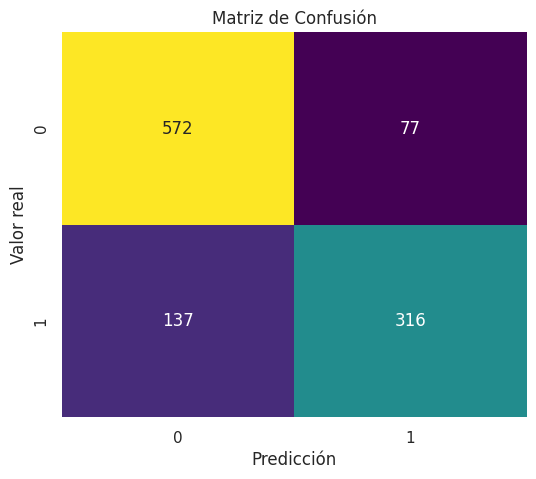

In [193]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()

Vemos que parece ser que el modelo clasifica mejor los verdaderos negativos que los verdaderos positivos, debido a las cantidades que vemos en la matriz, pero esto se realizo con la probabilidad de corte estandar 0,5 que tiene predict.

Procedemos a realizar un analisis de como varían las metricas segun el valor que utilizamos como probabilidad de corte.

#### Analisis de Predict Proba

In [194]:
def plot_precision_accuracy_vs_threshold(model, X, y):
    y_proba = model.predict_proba(X)[:, 1]

    thresholds = np.linspace(0.01, 0.99, 100)
    precisions = []
    accuracies = []

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precisions.append(precision_score(y, y_pred, zero_division=0))
        accuracies.append(accuracy_score(y, y_pred))

    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precisions, label='Precision', color='blue', linewidth=2)
    plt.plot(thresholds, accuracies, label='Accuracy', color='green', linewidth=2)

    max_prec_idx = np.argmax(precisions)
    max_acc_idx = np.argmax(accuracies)
    plt.scatter(thresholds[max_prec_idx], precisions[max_prec_idx], color='blue', marker='o', label='Max Precision')
    plt.scatter(thresholds[max_acc_idx], accuracies[max_acc_idx], color='green', marker='o', label='Max Accuracy')

    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.05)
    plt.xticks(np.arange(0.0, 1.01, 0.1))
    plt.yticks(np.arange(0.0, 1.05, 0.1))

    plt.xlabel('Threshold de predict_proba', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Precision y Accuracy vs Threshold', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

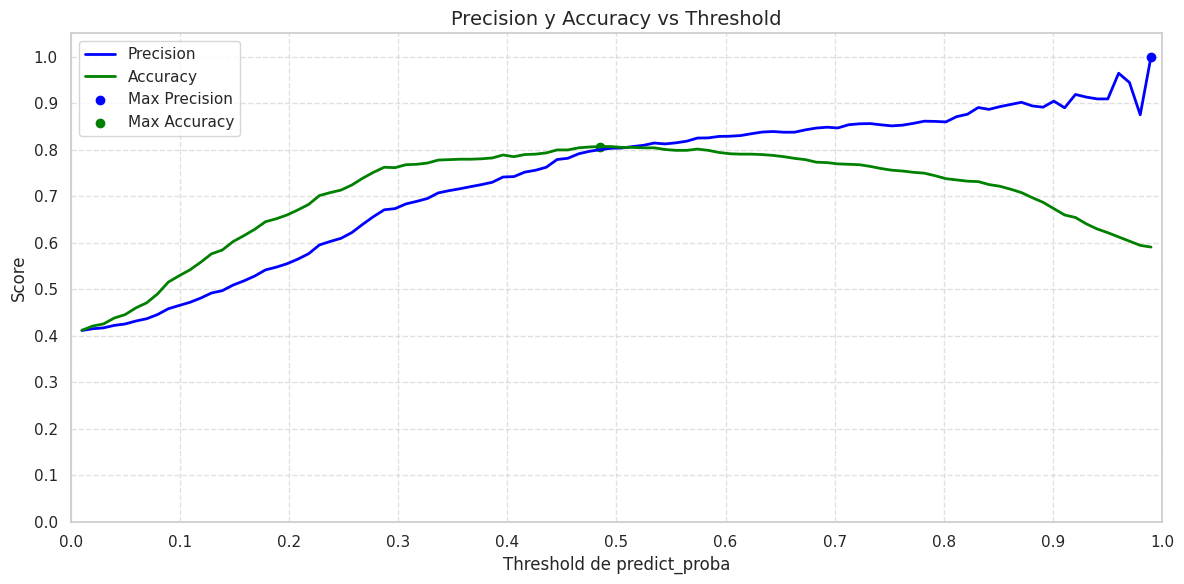

In [195]:
plot_precision_accuracy_vs_threshold(pipeline, X_test, y_test)

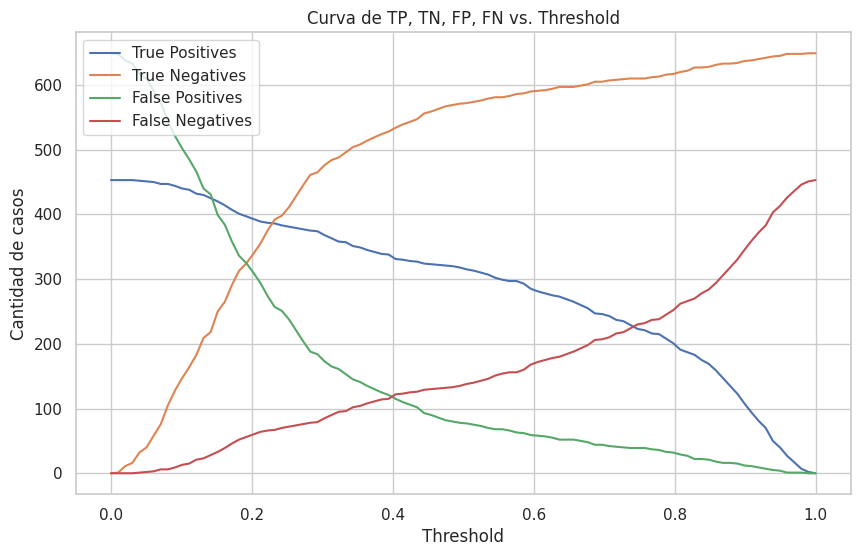

In [196]:
y_scores = pipeline.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 100)
tp_list, tn_list, fp_list, fn_list = [], [], [], []

for thresh in thresholds:
    y_pred = (y_scores >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, tp_list, label='True Positives')
plt.plot(thresholds, tn_list, label='True Negatives')
plt.plot(thresholds, fp_list, label='False Positives')
plt.plot(thresholds, fn_list, label='False Negatives')
plt.xlabel('Threshold')
plt.ylabel('Cantidad de casos')
plt.title('Curva de TP, TN, FP, FN vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

Debemos buscar el valor de threshold con maximo valor de la curva azul (TP: verdaderos positivos) y amarilla (TN: verdaderos negativos). Y minimo valor de las curvas roja (FN: falsos negativos) y verde (FP: falsos positivos).

Elegimos 0.59 en base al analisis de threshold.

In [197]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

for threshold in [round(x * 0.01, 2) for x in range(20, 96)]:
    y_pred_custom = (y_proba >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred_custom)
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    print(f"predict proba = {threshold:.2f} accuracy = {acc:.4f}, precision = {prec:.4f}, recall = {rec:.4f}, f1 = {f1:.4f}")

predict proba = 0.20 accuracy = 0.6615, precision = 0.5565, recall = 0.8698, f1 = 0.6787
predict proba = 0.21 accuracy = 0.6724, precision = 0.5669, recall = 0.8609, f1 = 0.6836
predict proba = 0.22 accuracy = 0.6878, precision = 0.5820, recall = 0.8543, f1 = 0.6923
predict proba = 0.23 accuracy = 0.7015, precision = 0.5954, recall = 0.8543, f1 = 0.7017
predict proba = 0.24 accuracy = 0.7078, precision = 0.6028, recall = 0.8477, f1 = 0.7046
predict proba = 0.25 accuracy = 0.7160, precision = 0.6125, recall = 0.8411, f1 = 0.7088
predict proba = 0.26 accuracy = 0.7269, precision = 0.6254, recall = 0.8366, f1 = 0.7158
predict proba = 0.27 accuracy = 0.7414, precision = 0.6433, recall = 0.8322, f1 = 0.7257
predict proba = 0.28 accuracy = 0.7568, precision = 0.6631, recall = 0.8300, f1 = 0.7373
predict proba = 0.29 accuracy = 0.7613, precision = 0.6703, recall = 0.8256, f1 = 0.7399
predict proba = 0.30 accuracy = 0.7613, precision = 0.6740, recall = 0.8124, f1 = 0.7367
predict proba = 0.31 

#### Resultado con predict proba

In [198]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

threshold = 0.59
y_pred_custom = (y_proba >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

Accuracy: 0.7976406533575318
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       649
           1       0.83      0.64      0.72       453

    accuracy                           0.80      1102
   macro avg       0.81      0.77      0.78      1102
weighted avg       0.80      0.80      0.79      1102



La consigna pide "atrapar tantos '1' como sea posible y minimizar los falsos positivos", por lo que entendemos que el objetivo es conseguir la **mayor precision** posible manteniendo un **recall** y **accuracy aceptable**.

Dado que los falsos positivos implican consecuencias más graves (como la aplicación de un tratamiento invasivo frente a una enfermedad menos riesgosa), consideramos prioritario **optimizar la métrica de precisión**, aún a costa de una leve reducción en el recall.

En base al analisis realizado decidimos utilizar un threshold de 0.59. De esta manera, mejoramos un poco la precision (mejora de 0,8 a 0,83), es decir disminuimos los falsos positivos, a costa de reducir levemente el recall (disminuye de 0,7 a 0,64) y por consiguiente el accuracy del modelo (disminuye de 0,81 a 0,8).



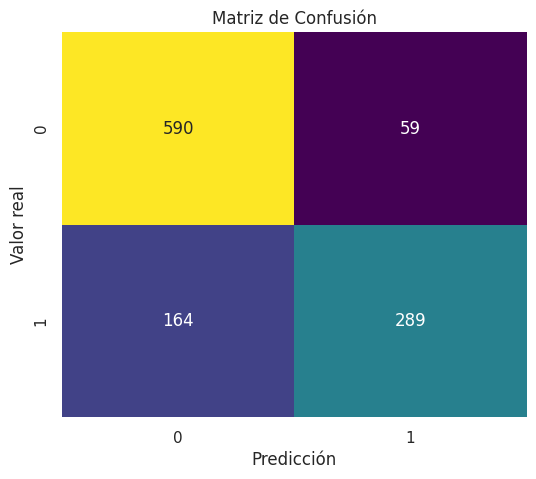

In [199]:
cm = confusion_matrix(y_test, y_pred_custom)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()

### Undersampling

Probamos realizar un undersampling para ver si el ligero desbalance de la clase `target` puede estar afectando al modelo.

In [200]:
df_under=df.copy()

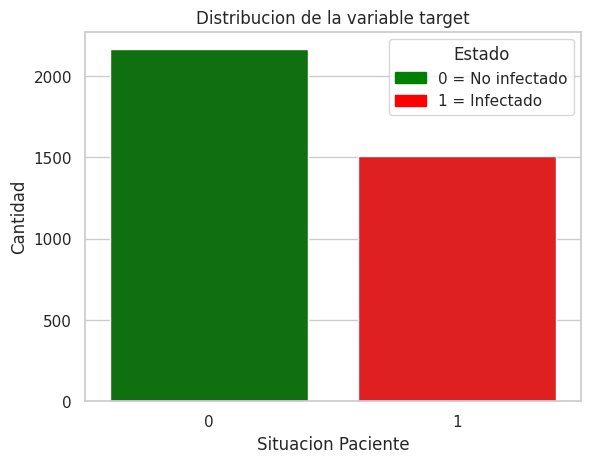

In [201]:
sns.countplot(x='target', hue='target', data=df_under, palette=['green', 'red'], legend=False)
plt.xlabel('Situacion Paciente')
plt.ylabel('Cantidad')
plt.title('Distribucion de la variable target')

patch_no_infectado = mpatches.Patch(color='green', label='0 = No infectado')
patch_infectado = mpatches.Patch(color='red', label='1 = Infectado')

plt.legend(handles=[patch_no_infectado, patch_infectado], title='Estado')

plt.show()

In [202]:
X = df_under[df_under.columns.drop('target')]
y = df_under['target']

In [203]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [204]:
df_res = pd.concat([X_res, y_res], axis=1)

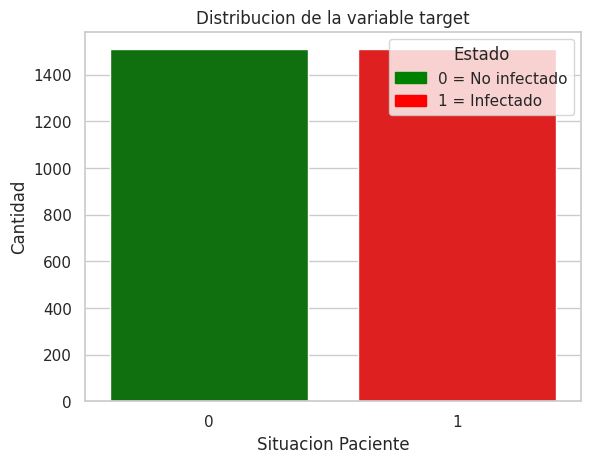

In [205]:
sns.countplot(x='target', hue='target', data=df_res, palette=['green', 'red'], legend=False)
plt.xlabel('Situacion Paciente')
plt.ylabel('Cantidad')
plt.title('Distribucion de la variable target')

patch_no_infectado = mpatches.Patch(color='green', label='0 = No infectado')
patch_infectado = mpatches.Patch(color='red', label='1 = Infectado')

plt.legend(handles=[patch_no_infectado, patch_infectado], title='Estado')

plt.show()

Vemos como luego de aplicar undersampling ambas clases tienen igual cantidad de registros, evitando posibles sesgos.

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=42)

In [207]:
pipeline_preprocesamiento_under = Pipeline(steps=[
    ('eliminar_features', EliminarFeatures(columns_to_drop=['Genero', 'Peso', 'Laboral', 'REC5', 'REC2', 'REC3', 'REC4', 'LVL'])),
    ('imputar_edad', ColSimpleImputer(columns=['Edad'])),
    ('imputar_outliers', ColOutliersImputer(columns=['BLD01', 'REC1', 'BLD02', 'BLD03'])),
    ('escalar', FullStandardScaler())
])

pipeline_under = Pipeline(steps=[
    ('prep', pipeline_preprocesamiento_under),
    ('clasificador', rf_model)
])

In [208]:
pipeline_under.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 Pipeline(steps=[('eliminar_features',
                                  EliminarFeatures(columns_to_drop=['Genero',
                                                                    'Peso',
                                                                    'Laboral',
                                                                    'REC5',
                                                                    'REC2',
                                                                    'REC3',
                                                                    'REC4',
                                                                    'LVL'])),
                                 ('imputar_edad',
                                  ColSimpleImputer(columns=['Edad'])),
                                 ('imputar_outliers',
                                  ColOutliersImputer(columns=['BLD01', 'REC1',
                                                              'BLD02',
                                                              'BLD03'])),
                                 ('escalar', FullStandardScaler())])),
                ('clasificador',
                 RandomForestClassifier(criterion='entropy', max_depth=26,
                                        n_estimators=312, random_state=42))])

In [209]:
y_pred = pipeline_under.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7902869757174393
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       453
           1       0.81      0.75      0.78       453

    accuracy                           0.79       906
   macro avg       0.79      0.79      0.79       906
weighted avg       0.79      0.79      0.79       906



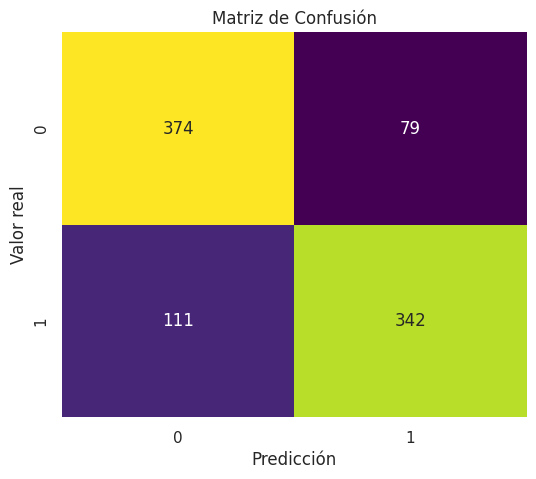

In [210]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()

La mejora más significativa que observamos al aplicar undersampling fue el aumento en el recall, que pasó de 0.70 a 0.75. La métrica de precisión también mostró una leve mejora de 0.01, mientras que el accuracy se vio ligeramente afectado, disminuyendo en 0.02.

Vamos a realizar otro analisis de predict proba para intentar trasladar la mejora en la metrica de recall hacia la metrica de precision.

#### Analisis de Predict Proba


In [211]:
def plot_precision_accuracy_vs_threshold(model, X, y):
    y_proba = model.predict_proba(X)[:, 1]

    thresholds = np.linspace(0.01, 0.99, 100)
    precisions = []
    accuracies = []

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precisions.append(precision_score(y, y_pred, zero_division=0))
        accuracies.append(accuracy_score(y, y_pred))

    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precisions, label='Precision', color='blue', linewidth=2)
    plt.plot(thresholds, accuracies, label='Accuracy', color='green', linewidth=2)

    # Máximos
    max_prec_idx = np.argmax(precisions)
    max_acc_idx = np.argmax(accuracies)
    plt.scatter(thresholds[max_prec_idx], precisions[max_prec_idx], color='blue', marker='o', label='Max Precision')
    plt.scatter(thresholds[max_acc_idx], accuracies[max_acc_idx], color='green', marker='o', label='Max Accuracy')

    # Ejes, ticks y límites
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.05)
    plt.xticks(np.arange(0.0, 1.01, 0.1))
    plt.yticks(np.arange(0.0, 1.05, 0.1))

    # Estética
    plt.xlabel('Threshold de predict_proba', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Precision y Accuracy vs Threshold', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

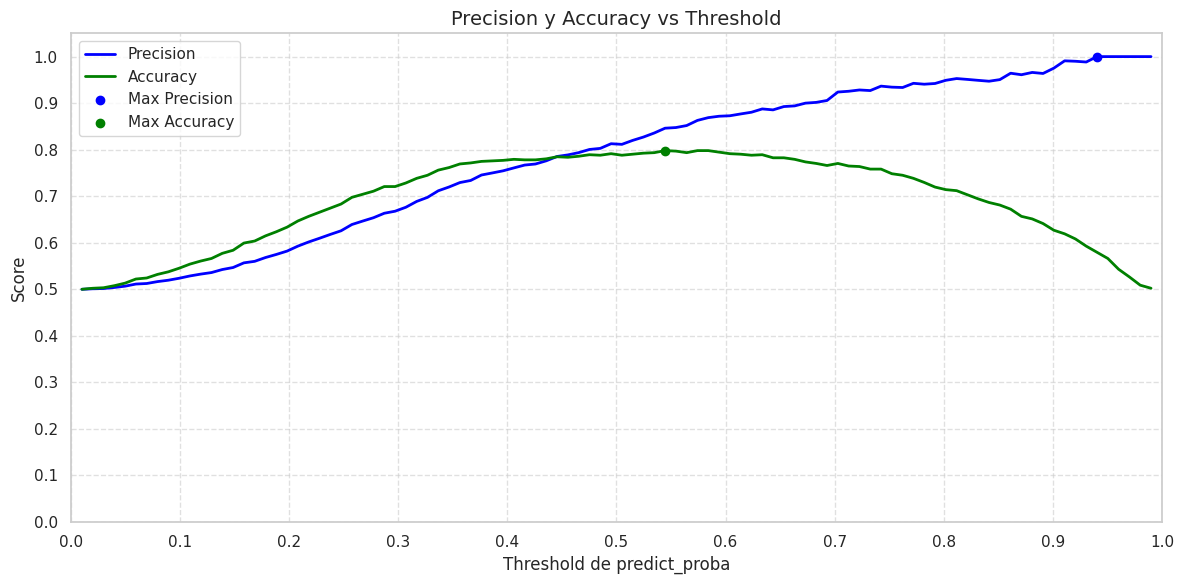

In [212]:
plot_precision_accuracy_vs_threshold(pipeline_under, X_test, y_test)

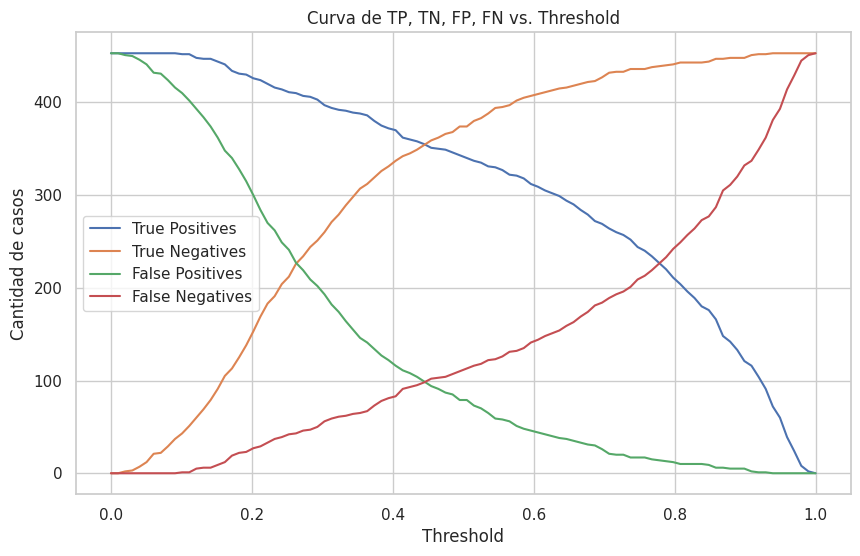

In [213]:
y_scores = pipeline_under.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 100)
tp_list, tn_list, fp_list, fn_list = [], [], [], []

for thresh in thresholds:
    y_pred = (y_scores >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, tp_list, label='True Positives')
plt.plot(thresholds, tn_list, label='True Negatives')
plt.plot(thresholds, fp_list, label='False Positives')
plt.plot(thresholds, fn_list, label='False Negatives')
plt.xlabel('Threshold')
plt.ylabel('Cantidad de casos')
plt.title('Curva de TP, TN, FP, FN vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

Debemos buscar el valor de threshold con maximo valor de la curva azul (TP: verdaderos positivos) y amarilla (TN: verdaderos negativos). Y minimo valor de las curvas roja (FN: falsos negativos) y verde (FP: falsos positivos).

Elegimos 0.58 en base al analisis de threshold.

In [214]:
y_proba = pipeline_under.predict_proba(X_test)[:, 1]

for threshold in [round(x * 0.01, 2) for x in range(20, 96)]:
    y_pred_custom = (y_proba >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred_custom)
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    print(f"predict proba = {threshold:.2f} accuracy = {acc:.4f}, precision = {prec:.4f}, recall = {rec:.4f}, f1 = {f1:.4f}")

predict proba = 0.20 accuracy = 0.6369, precision = 0.5845, recall = 0.9470, f1 = 0.7228
predict proba = 0.21 accuracy = 0.6512, precision = 0.5963, recall = 0.9360, f1 = 0.7285
predict proba = 0.22 accuracy = 0.6645, precision = 0.6078, recall = 0.9272, f1 = 0.7343
predict proba = 0.23 accuracy = 0.6678, precision = 0.6118, recall = 0.9183, f1 = 0.7343
predict proba = 0.24 accuracy = 0.6788, precision = 0.6216, recall = 0.9139, f1 = 0.7399
predict proba = 0.25 accuracy = 0.6854, precision = 0.6277, recall = 0.9117, f1 = 0.7435
predict proba = 0.26 accuracy = 0.6998, precision = 0.6416, recall = 0.9051, f1 = 0.7509
predict proba = 0.27 accuracy = 0.7064, precision = 0.6486, recall = 0.9007, f1 = 0.7542
predict proba = 0.28 accuracy = 0.7152, precision = 0.6580, recall = 0.8962, f1 = 0.7589
predict proba = 0.29 accuracy = 0.7208, precision = 0.6645, recall = 0.8918, f1 = 0.7615
predict proba = 0.30 accuracy = 0.7230, precision = 0.6700, recall = 0.8786, f1 = 0.7603
predict proba = 0.31 

Buscamos maximizar el valor de las metricas **recall**, **accuracy** y **precision**. En
base a la lista anterior elegimos un **threshold** de 0.58, obteniendo un valor de **precision** de 0.87 lo cual nos ayuda a minimizar los falsos positivos.

Aunque es posible aumentar aún más la precisión, debemos encontrar un **equilibrio con el resto de métricas**. Si bien la precisión es nuestra prioridad, una reducción significativa del recall implicaría que el modelo comete muchos falsos negativos, es decir, que clasifica como no infectadas a personas que sí lo están, lo cual  no sería correcto.

Consideramos no aumentar mas el threshold ya que el accuracy y el recall del modelo empeoraban demasiado.

#### Resultado con predict proba

In [215]:
y_proba = pipeline_under.predict_proba(X_test)[:, 1]

threshold = 0.58
y_pred_custom = (y_proba >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

Accuracy: 0.7991169977924945
              precision    recall  f1-score   support

           0       0.75      0.89      0.82       453
           1       0.87      0.71      0.78       453

    accuracy                           0.80       906
   macro avg       0.81      0.80      0.80       906
weighted avg       0.81      0.80      0.80       906



* Al comparar con el modelo original (sin undersampling ni ajuste del threshold), vemos que el accuracy baja levemente (0.01), mientras que el recall mejora en igual medida. Lo más destacable es que la precision aumenta 0.07, lo cual representa una mejora clara en la reducción de falsos positivos.

* Si lo comparamos con el modelo original pero ajustando el threshold, el accuracy se mantiene en 0.80 y el recall mejora 0.07. En este caso, la precision también sube (0.04), lo cual sigue siendo una mejora en la detección correcta de positivos reales sin aumentar los falsos positivos.

* Por último, al comparar con el modelo con undersampling pero sin ajuste de threshold, vemos que el accuracy sube levemente (0.01), pero el recall cae 0.04. De todas formas, la precision aumenta 0.06, lo que nuevamente indica una mejor clasificación en términos de falsos positivos.

En general, estos resultados son positivos, ya que además de cumplir con el objetivo principal de reducir los falsos positivos, también logramos mantener (o incluso mejorar) la capacidad del modelo para detectar correctamente los casos positivos reales.

Como este modelo logró el mejor balance entre **precision**, **recall** y **accuracy**, lo seleccionamos como nuestro **clasificador final**.

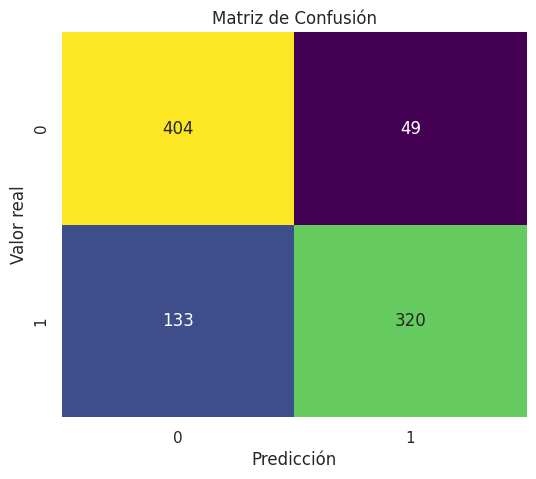

In [216]:
cm = confusion_matrix(y_test, y_pred_custom)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()

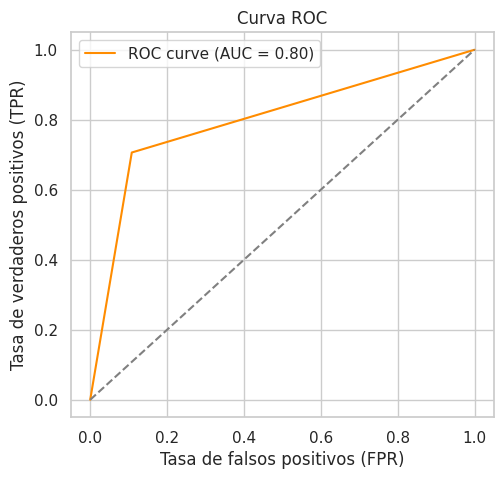

In [217]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_custom)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)

Finalmente vemos la curva ROC, la cual muestra que el modelo al que llegamos es bueno ya que se encuentra en la parte superior de la funcion identidad, y esto indica que tenemos **mas verdaderos positivos clasificados correctamente que falsos positivos**.

## 5) Optimizacion

En esta seccion vamos a explicar como llegamos a la seleccion del modelo final, la consifguracion de sus hiperparametros y la seleccion de features.

### Explicacion de las optimizaciones realizadas


La primer pruba que hicimos fue utilizar **Grid Search** para explorar diferentes modelos y combinaciones de hiperparámetros con el fin de encontrar los mejores resultados. En esta etapa, el objetivo principal fue establecer un baseline, por lo que no realizamos selección de features y empleamos todas las variables disponibles para la clasificación, exceptuando el target.

In [218]:
x_target = df.drop('target', axis=1)
y_target = df['target']

X_train, X_test, y_train, y_test = train_test_split(x_target, y_target, test_size=0.3, stratify = y_target, random_state=42)

In [219]:
class ColOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, encoder=None, columns=[]):
        super().__init__()
        self.encoder = encoder
        self.columns = columns

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def get_feature_names_out(self):
        return self.encoder.get_feature_names_out()

    def  transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.encoder.get_feature_names_out()] = self.encoder.transform(Xc.loc[:,self.columns])
        Xc.drop(self.columns, axis=1, inplace=True)
        return Xc

In [220]:
class ColImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(), columns=[]):
        super().__init__()
        self.imputer = imputer
        self.columns = columns

    def fit(self, X, y=None):
        self.imputer.fit(X[self.columns])
        return self

    def get_feature_names_out(self):
        return self.imputer.get_feature_names_out()

    def transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.columns] = self.imputer.transform(Xc[self.columns])
        return Xc

Utilizamos una clase para transformar variables categóricas mediante **One Hot Encoder**, y otra para imputar valores nulos, lo que nos permitió elegir el imputador más adecuado para cada variable.

In [221]:
pipeline_comparacion = Pipeline(steps=[
    ('imputar_edad', ColSimpleImputer(columns=['Edad'])),
    ("ImpGen", ColImputer(imputer=SimpleImputer(strategy='most_frequent'), columns=["Genero"])),
    ("ImpLVL", ColImputer(imputer=SimpleImputer(strategy='median'), columns=["LVL"])),
    ("OneHot", ColOneHot(encoder=OneHotEncoder(sparse_output=False, drop='first', dtype=int), columns=["Genero","Laboral"])),
    ('imputar_outliers', ColOutliersImputer(columns=['BLD01', 'REC1', 'REC2', 'REC4', 'REC5', 'BLD02', 'BLD03', 'LVL'])),
    ('escalar', FullStandardScaler()),
])

Para el scoring del Grid Search, seleccionamos la métrica precision dado que buscamos minimizar los falsos positivos en nuestro modelo.

**Aclaración**: Se redujo el rango de búsqueda para que la ejecución de la celda se realice en un tiempo razonable.

In [222]:
modelos = {
    "LogisticRegression": Pipeline([
        ('pre',pipeline_comparacion),
        ('clf', LogisticRegression())
    ]),
    "DecisionTree": Pipeline([
        ('pre',pipeline_comparacion),
        ('clf', DecisionTreeClassifier())
    ]),
    "RandomForest": Pipeline([
        ('pre',pipeline_comparacion),
        ('clf', RandomForestClassifier())
    ]),
    "KNN": Pipeline([
        ('pre',pipeline_comparacion),
        ('clf', KNeighborsClassifier())
    ]),
    "NaiveBayes": Pipeline([
        ('pre', pipeline_comparacion),
        ('clf', GaussianNB())
    ])
}

param_grids = {
    'LogisticRegression': {
        'clf__C': [0.1, 1],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear']
    },
    'DecisionTree': {
        'clf__max_leaf_nodes': [50,200],
        'clf__max_depth': [3, 5, 10, None],
        'clf__min_samples_split': [2, 5, 10]
    },
    'RandomForest': {
        'clf__n_estimators': [100, 200],
        'clf__max_leaf_nodes': [50, 200],
        'clf__max_depth': [5, 10, None],
        'clf__min_samples_split': [2, 5],
    },
    'KNN': {
        'clf__n_neighbors': [19, 21, 23],
        'clf__metric': ['euclidean', 'manhattan']
    },
    'NaiveBayes': {
        'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    }
}
grid_results = {}
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for name, pipeline in modelos.items():
    grid_pre = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=cv,
        scoring='precision',
        n_jobs=-1,
        verbose=1
    )

    grid_pre.fit(X_train, y_train)
    grid_results[name] = grid_pre

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Fitting 2 folds for each of 24 candidates, totalling 48 fits
Fitting 2 folds for each of 24 candidates, totalling 48 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [223]:
for name, grid in grid_results.items():
    print(f"\nModelo: {name}")
    print("Mejores parámetros:", grid.best_params_)
    print("Precision en test:", grid.score(X_test, y_test))


Modelo: LogisticRegression
Mejores parámetros: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Precision en test: 0.7513661202185792

Modelo: DecisionTree
Mejores parámetros: {'clf__max_depth': 5, 'clf__max_leaf_nodes': 200, 'clf__min_samples_split': 2}
Precision en test: 0.7926829268292683

Modelo: RandomForest
Mejores parámetros: {'clf__max_depth': 5, 'clf__max_leaf_nodes': 50, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Precision en test: 0.7777777777777778

Modelo: KNN
Mejores parámetros: {'clf__metric': 'manhattan', 'clf__n_neighbors': 23}
Precision en test: 0.7708333333333334

Modelo: NaiveBayes
Mejores parámetros: {'clf__var_smoothing': 1e-09}
Precision en test: 0.7003154574132492


En base a la busqueda exhaustiva realizada para encontrar que parametros mejoraban la precision, podemos ver que los mejores resultados fueron los modelos de arboles.

Para profundizar en la comparacion, decidimos utilizar RandomizedSearchCV entre los 5 modelos vistos en clase:

> **Primer intento**

Comenzamos realizando una clasificación KNN para obtener una línea base de referencia para futuros modelos.  
El valor de precision obtenido fue: 0.77

> **Segundo intento**

Luego, decidimos crear nuestro propio clasificador, basado en un Voting Classifier que incluía los modelos vistos en clase:
* KNN
* Decision Tree
* Logistic Regression
* Random Forest
* Naive Bayes

A este clasificador le optimizamos sus hiperparámetros mediante RandomizedSearchCV.  
El valor de precision resultante fue: 0.7738

> **Tercer intento**

La primera comparación entre los modelos vistos en clase arrojó los siguientes resultados en términos de precision:

* KNN precision: 0.7563
* Decision Tree precision: 0.6667
* Logistic Regression precision: 0.7563
* Random Forest precision: 0.7897
* Naive Bayes precision: 0.7214

Adicionalmente, lo comparamos con el Voting Classifier que creamos manualmente:
* Voting Classifier precision: 0.7738

Pudimos apreciar que Random Forest, incluso con valores iniciales aleatorios, superaba al modelo por votación. Por ello, decidimos utilizar Random Forest.

> **Cuarto intento**

Aplicamos RandomizedSearchCV a cada uno de los cinco modelos por separado para comparar, en igualdad de condiciones, cuál era el mejor. Los resultados fueron los siguientes:

* KNN precision (optimizado): 0.7563
* Decision Tree precision (optimizado): 0.7611
* Logistic Regression precision (optimizado): 0.7563
* Random Forest precision (optimizado): 0.7937  
  * Mejores parámetros para Random Forest:  
    `{'bootstrap': True, 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 101}`
* Naive Bayes precision: 0.7214

Nuevamente, **Random Forest** se destaca como el mejor modelo para realizar la clasificación.







### Optimizacion de hiperparametros de RandomForest

Una vez seleccionado el modelo **Random Forest Classifier** como clasificador principal, utilizamos RandomizedSearchCV para optimizar sus hiperparámetros.

Realizamos diferentes ejecuciones variando la cantidad de iteraciones y el tiempo de ejecución, con el objetivo de comparar los resultados y seleccionar la mejor configuración.

**Aclaracion**: Acotamos el rango de busqueda para que de un resultado simnilar al que obtuvimos nosotros. Ademas, se redujo la cantidad de iteraciones para ahorrar tiempo de ejecucion.

In [224]:
X_train_preprocesado = pipeline_comparacion.fit_transform(X_train,y_train)
X_test_preprocesado = pipeline_comparacion.transform(X_test)

param_dist_rf = {
    'n_estimators': randint(312, 313),
    'max_depth': randint(26, 27),
    'min_samples_split': randint(2, 3),
    'min_samples_leaf': randint(1, 2),
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'criterion': ['entropy']
}

rf = RandomForestClassifier(random_state=42)

rs_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=2, # Redujimos las iteraciones para que ejecute en un tiempo razonable
    cv=5,
    scoring='precision',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rs_rf.fit(X_train_preprocesado, y_train)

print("Mejores parametros para Random Forest:")
print(rs_rf.best_params_)

best_rf = rs_rf.best_estimator_
preds_rf = best_rf.predict(X_test_preprocesado)
acc_rf = precision_score(y_test, preds_rf)
print(f"Random Forest Precision (optimizado): {acc_rf:.4f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Mejores parametros para Random Forest:
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 26, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 312}
Random Forest Precision (optimizado): 0.7833


Los mejores hiperparametros encontrados fueron los siguientes:

*   n_estimators=312
*   max_depth=26
*   min_samples_split=2
*   min_samples_leaf=1
*   max_features='sqrt'
*   bootstrap=True
*   criterion='entropy'

La **precision** alcanzada fue de 0.7833



### Test de Permutacion

               feature  importance_mean  importance_std
0                 Edad     1.025408e-01        0.000000
1                 Peso     2.676951e-02        0.004991
9                BLD02     2.540835e-02        0.002722
10               BLD03     1.860254e-02        0.002269
3                BLD01     1.225045e-02        0.003176
4                 REC1     4.990926e-03        0.001361
5                 REC2     4.990926e-03        0.001361
14    Laboral_Inactivo     4.537205e-03        0.000000
7                 REC4     2.268603e-03        0.001361
11                 LVL     1.361162e-03        0.000454
12    Genero_Masculino     1.361162e-03        0.000454
15  Laboral_No_declara     9.074410e-04        0.000000
13         Genero_Otro     0.000000e+00        0.000000
8                 REC5    -5.551115e-17        0.000907
6                 REC3    -9.074410e-04        0.000907


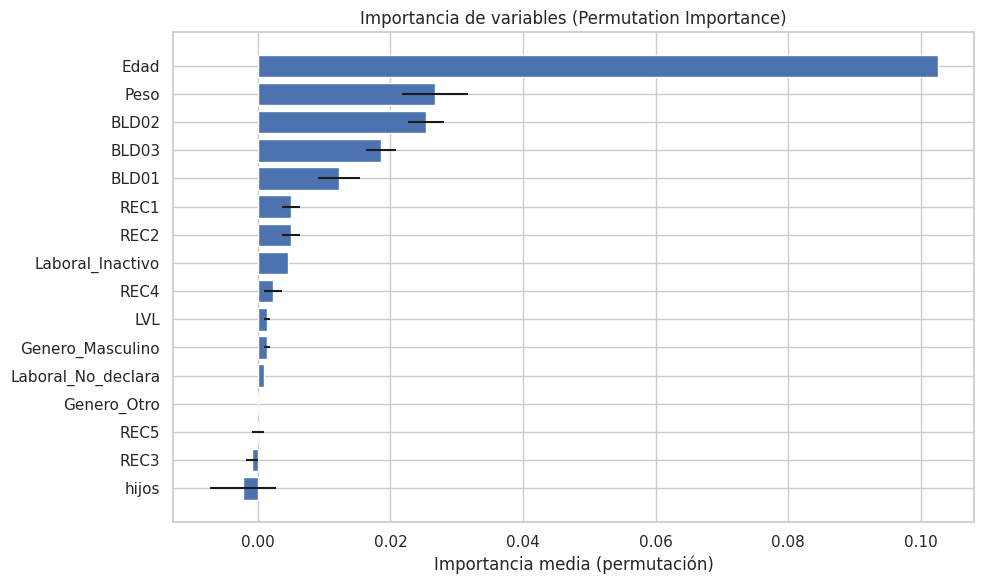

In [225]:
model = best_rf
result = permutation_importance(estimator=model, X=X_test_preprocesado, y=y_test, n_repeats=2, random_state=0)

importancias = pd.DataFrame({
    'feature': X_test_preprocesado.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importancias.head(15))

plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importance_mean'], xerr=importancias['importance_std'])
plt.xlabel('Importancia media (permutación)')
plt.title('Importancia de variables (Permutation Importance)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Realizamos un test de permutacion para poder filtrar features, vemos que las variables `Edad`, `Peso`, `BLD01`, `BLD02`, `BLD03` y `REC1` son las 6 mas importantes. Probamos utilizando estas variables pero comprobamos que sacar la variable `Peso` del modelo mejoraba el score.

Sacamos esa variable debido a que en el analisis bivariable podíamos ver que la combinacion `Peso` - `Edad` no separaba claramente a las personas infectadas y no infectadas.

En el ultimo modelo desarrollado, tambien agregamos la columna `Hijos`, no por este test de permutacion sino debido al resultado del analisis bivariable del comienzo, donde se podía ver que separaba ambos colores. Lo comprobamos y esta columna mejora el modelo.

# Evaluacion final - Docente + Alumno

In [250]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

PRODUCCION = False
best_clf = pipeline_under #Asignar aqui el mejor clasificador/pipeline posible (previamente entrenado si es necesario)

#Leemos el dataset de evaluación, simulando producción
if PRODUCCION==False:
    df = pd.read_csv("TP_Virus_Alumnos.csv")
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv("TP_Virus_Evaluacion.csv")
#Dividimos en target y predictoras

X_prod = df.drop("target", axis=1)
y_prod = df["target"]

#Transformaciones en caso de no ser un pipeline completo. Preferiblemente, el mejor pipeline debe incluir todas las transformaciones necesarias.
#Si es pipeline ejecutar el fit (tener en cuenta el tiempo). Si mediante exploración / busqueda exhaustiva se encontró el mejor clasificador
#harcodear sus hiperparametros (Adjuntar código y explicación de como se encontró el mejor clasificador).

# Ajuste de predict proba
threshold = 0.58
y_proba = best_clf.predict_proba(X_prod)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

#Evaluación final
#y_pred = best_clf.predict(X_prod)
print(classification_report(y_prod, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       739
           1       0.89      0.88      0.88       521

    accuracy                           0.91      1260
   macro avg       0.90      0.90      0.90      1260
weighted avg       0.91      0.91      0.91      1260



El **pipeline_under** que usamos como **best_clf** debe estar entrenado con el archivo "TP_Virus_Alumnos.csv" y no es necesario hace el fit nuevamente, se puede utilizar directamente para la prediccion, si se ejecuta completo el archivo de jupyter.

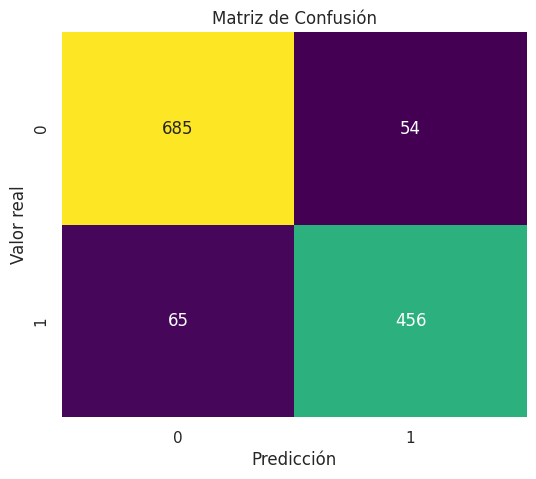

In [251]:
cm = confusion_matrix(y_prod, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()

# Anexo

En esta sección se incluyen fragmentos de código y funciones auxiliares que utilizamos para el preprocesamiento y la validación de modelos, como la definición de pipelines parametrizables, rutinas de imputación y escalado, entre otros, que fuimos probando y terminaron siendo descartados.

## Analisis Eliminación de Registros con valores Nulos

### Eliminacion de registros con Edad nulo

In [252]:
"""
df = df.dropna(subset=["Edad"])
print(df["Edad"].isna().sum())
"""

'\ndf = df.dropna(subset=["Edad"])\nprint(df["Edad"].isna().sum())\n'

Probamos eliminar las filas con valores faltantes en la variable edad, pero debido al tamaño reducido del dataset, esta eliminación afectó significativamente el desempeño del modelo, resultando en un rendimiento inferior al de las versiones con edades imputadas.

### Eliminacion de registros con Genero nulo

In [253]:
"""
df = df.dropna(subset=["Genero"])
print(df["Genero"].isna().sum())
"""

'\ndf = df.dropna(subset=["Genero"])\nprint(df["Genero"].isna().sum())\n'


Eliminar los registros con genero nulo no producia ninguna mejora o deterioro significante en el mdoelo final. Debido al tamaño del dataset, decidimos dejar estos registros y realizar una tecnica de imputacion para asignarles un valor al genero.

## Analisis Balanceo de la variable target

Observamos que realizar oversampling sobre la variable target empeoraba el desempeño del modelo en comparación con no aplicar ninguna técnica de balanceo.

También probamos con undersampling, y dado que esta estrategia mejoró los resultados, decidimos incorporarla en la versión final del modelo.

## Clases Imputadoras y Tranformadoras

### Imputador para la variable Genero

Este transformador personalizado lo utilizamos aplicando una estrategia basada en Random Forest para imputar los valores faltantes en la columna `Genero`. Se incluye en el anexo como ejemplo de enfoque mejorado de imputación, aunque finalmente lo descartamos por no mejorar significativamente el rendimiento.

In [254]:
"""
class ColComplexImputerGenero(BaseEstimator, TransformerMixin):
    def __init__(self, column='Genero', feature_columns=None, random_state=42):
        self.column = column
        self.feature_columns = feature_columns
        self.model = RandomForestClassifier(random_state=random_state)
        self.random_state = random_state
        self.fitted_features = None
        self.label_encoders = {}

    def fit(self, X, y=None):
        X = X.copy()

        train_df = X[X[self.column].notna()]

        if self.feature_columns is None:
            cols_to_exclude = [self.column, 'Laboral', 'Genero']
            self.feature_columns = [col for col in train_df.columns if col not in cols_to_exclude]

        self.fitted_features = self.feature_columns

        train_aux = train_df[self.fitted_features].copy()

        for col in self.fitted_features:
            if train_aux[col].dtype == 'object' or str(train_aux[col].dtype).startswith('category'):
                le = LabelEncoder()
                train_aux[col] = le.fit_transform(train_aux[col].astype(str))
                self.label_encoders[col] = le
            else:
                self.label_encoders[col] = None

        self.model.fit(train_aux, train_df[self.column])
        return self

    def transform(self, X):
        X = X.copy()

        mask_na = X[self.column].isna()

        if mask_na.any():
            X_pred = X.loc[mask_na, self.fitted_features].copy()

            for col, le in self.label_encoders.items():
                if le is not None:
                    X_pred[col] = X_pred[col].astype(str)
                    X_pred[col] = X_pred[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

            pred = self.model.predict(X_pred)
            X.loc[mask_na, self.column] = pred

        X[self.column] = X[self.column].fillna('Otro')

        return X
"""

"\nclass ColComplexImputerGenero(BaseEstimator, TransformerMixin):\n    def __init__(self, column='Genero', feature_columns=None, random_state=42):\n        self.column = column\n        self.feature_columns = feature_columns\n        self.model = RandomForestClassifier(random_state=random_state)\n        self.random_state = random_state\n        self.fitted_features = None\n        self.label_encoders = {}\n\n    def fit(self, X, y=None):\n        X = X.copy()\n\n        train_df = X[X[self.column].notna()]\n\n        if self.feature_columns is None:\n            cols_to_exclude = [self.column, 'Laboral', 'Genero']\n            self.feature_columns = [col for col in train_df.columns if col not in cols_to_exclude]\n\n        self.fitted_features = self.feature_columns\n\n        train_aux = train_df[self.fitted_features].copy()\n\n        for col in self.fitted_features:\n            if train_aux[col].dtype == 'object' or str(train_aux[col].dtype).startswith('category'):\n             

### Imputador para la variable LVL

Este transformador imputa los valores nulos por el valor de Q3 (tercer cuartil). Se descarto ya que tomamos la decision de eliminar las files faltantes.

In [255]:
"""
class ColComplexImputerLVL(BaseEstimator, TransformerMixin):
    def __init__(self, columns=['LVL']):
        self.columns = columns
        self.q3_values = {}

    def fit(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            self.q3_values[col] = X[col].quantile(0.75)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X[col] = X[col].fillna(self.q3_values[col])
        return X

"""

"\nclass ColComplexImputerLVL(BaseEstimator, TransformerMixin):\n    def __init__(self, columns=['LVL']):\n        self.columns = columns\n        self.q3_values = {}\n\n    def fit(self, X, y=None):\n        X = X.copy()\n        for col in self.columns:\n            self.q3_values[col] = X[col].quantile(0.75)\n        return self\n\n    def transform(self, X):\n        X = X.copy()\n        for col in self.columns:\n            if col in X.columns:\n                X[col] = X[col].fillna(self.q3_values[col])\n        return X\n\n"

### Binner para la variable Edad

Intentamos agrupar los registros en 3 grupos etarios (joven, adulto y adulto mayor) segun lo vistos en el histograma que realizamos.

El modelo arrojaba peores resultados con esta nueva columna.

In [256]:
"""
class EdadBinner(BaseEstimator, TransformerMixin):
    def __init__(self, column='Edad', new_column='Edad_categoria'):
        self.column = column
        self.new_column = new_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_column] = pd.cut(
            X[self.column],
            bins=[-float('inf'), 20, 63, float('inf')],
            labels=['joven', 'adulto', 'adulto_mayor']
        )
        return X
  """

"\nclass EdadBinner(BaseEstimator, TransformerMixin):\n    def __init__(self, column='Edad', new_column='Edad_categoria'):\n        self.column = column\n        self.new_column = new_column\n\n    def fit(self, X, y=None):\n        return self\n\n    def transform(self, X):\n        X = X.copy()\n        X[self.new_column] = pd.cut(\n            X[self.column],\n            bins=[-float('inf'), 20, 63, float('inf')],\n            labels=['joven', 'adulto', 'adulto_mayor']\n        )\n        return X\n  "

### Feature KNN

In [257]:
"""
class KnnDistanceFeature(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=1, weights='uniform', p=2, leaf_size=30, features=None):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.p = p
        self.leaf_size = leaf_size
        self.features = features  # Lista de columnas a usar

    def fit(self, X, y):
        X_selected = X[self.features] if self.features else X
        self.X_fit_ = X_selected.copy()
        self.y_fit_ = y.copy()
        self.model = KNeighborsClassifier(
            n_neighbors=self.n_neighbors + 1,  # +1 para excluir el propio registro
            weights=self.weights,
            p=self.p,
            leaf_size=self.leaf_size,
            metric='minkowski'
        )
        self.model.fit(self.X_fit_, self.y_fit_)
        return self

    def transform(self, X):
        X_selected = X[self.features] if self.features else X
        distances, _ = self.model.kneighbors(X_selected)
        knn_dists = distances[:, self.n_neighbors]
        X_new = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        X_new['knn_dist'] = knn_dists
        return X_new
"""


"\nclass KnnDistanceFeature(BaseEstimator, TransformerMixin):\n    def __init__(self, n_neighbors=1, weights='uniform', p=2, leaf_size=30, features=None):\n        self.n_neighbors = n_neighbors\n        self.weights = weights\n        self.p = p\n        self.leaf_size = leaf_size\n        self.features = features  # Lista de columnas a usar\n\n    def fit(self, X, y):\n        X_selected = X[self.features] if self.features else X\n        self.X_fit_ = X_selected.copy()\n        self.y_fit_ = y.copy()\n        self.model = KNeighborsClassifier(\n            n_neighbors=self.n_neighbors + 1,  # +1 para excluir el propio registro\n            weights=self.weights,\n            p=self.p,\n            leaf_size=self.leaf_size,\n            metric='minkowski'\n        )\n        self.model.fit(self.X_fit_, self.y_fit_)\n        return self\n\n    def transform(self, X):\n        X_selected = X[self.features] if self.features else X\n        distances, _ = self.model.kneighbors(X_selected)

Probamos agregar una nueva columna con el resultado del modelo K-esimo vecino cercanos para ver si ayudaba al modelo de **Random Forest** a clasificar mejor. Luego de realizar distintas pruebas con diversos hiperparametros para el modelo de **KNN** decidimos descartar esta columna porque empeoraba los resultados.

## Modelos de Clasificacion

### Clasificador por Votacion

En una primera instancia, pensabamos utilizar un clasificador por votación con los modelos vistos en clase. Luego, comparandolo con cada modelo individualmente, daba peores resultados que **Random Forest**. Decidimos descartar la idea de utilizar un clasificador por votación.

In [258]:
"""
class VotingClassifierCustom(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 voting='soft',

                 # KNN
                 knn__n_neighbors=5,
                 knn__weights='uniform',
                 knn__p=2,
                 knn__leaf_size=30,

                 # Árbol de decisión
                 tree__max_depth=5,
                 tree__min_samples_split=2,
                 tree__min_samples_leaf=1,
                 tree__criterion='gini',
                 tree__splitter='best',
                 tree__max_features=None,

                 # Regresión logística
                 logreg__C=1.0,
                 logreg__penalty='l2',
                 logreg__solver='lbfgs',
                 logreg__class_weight=None,
                 logreg__fit_intercept=True,
                 logreg__max_iter=100,
                 logreg__tol=1e-4,
                 logreg__l1_ratio=None,

                 # Random Forest
                 rf__n_estimators=100,
                 rf__max_depth=10,
                 rf__min_samples_split=2,
                 rf__min_samples_leaf=1,
                 rf__max_features='sqrt',
                 rf__bootstrap=True,
                 rf__criterion='gini',

                 # Naive Bayes
                 nb__var_smoothing=1e-9):

        self.voting = voting

        # Save all parameters
        self.knn__n_neighbors = knn__n_neighbors
        self.knn__weights = knn__weights
        self.knn__p = knn__p
        self.knn__leaf_size = knn__leaf_size

        self.tree__max_depth = tree__max_depth
        self.tree__min_samples_split = tree__min_samples_split
        self.tree__min_samples_leaf = tree__min_samples_leaf
        self.tree__criterion = tree__criterion
        self.tree__splitter = tree__splitter
        self.tree__max_features = tree__max_features

        self.logreg__C = logreg__C
        self.logreg__penalty = logreg__penalty
        self.logreg__solver = logreg__solver
        self.logreg__class_weight = logreg__class_weight
        self.logreg__fit_intercept = logreg__fit_intercept
        self.logreg__max_iter = logreg__max_iter
        self.logreg__tol = logreg__tol
        self.logreg__l1_ratio = logreg__l1_ratio

        self.rf__n_estimators = rf__n_estimators
        self.rf__max_depth = rf__max_depth
        self.rf__min_samples_split = rf__min_samples_split
        self.rf__min_samples_leaf = rf__min_samples_leaf
        self.rf__max_features = rf__max_features
        self.rf__bootstrap = rf__bootstrap
        self.rf__criterion = rf__criterion

        self.nb__var_smoothing = nb__var_smoothing

        # Initialize classifiers
        self.models = [
            ('knn', KNeighborsClassifier(
                n_neighbors=self.knn__n_neighbors,
                weights=self.knn__weights,
                p=self.knn__p,
                leaf_size=self.knn__leaf_size)),

            ('tree', DecisionTreeClassifier(
                max_depth=self.tree__max_depth,
                min_samples_split=self.tree__min_samples_split,
                min_samples_leaf=self.tree__min_samples_leaf,
                criterion=self.tree__criterion,
                splitter=self.tree__splitter,
                max_features=self.tree__max_features)),

            ('logreg', LogisticRegression(
                C=self.logreg__C,
                penalty=self.logreg__penalty,
                solver=self.logreg__solver,
                class_weight=self.logreg__class_weight,
                fit_intercept=self.logreg__fit_intercept,
                max_iter=self.logreg__max_iter,
                tol=self.logreg__tol,
                l1_ratio=self.logreg__l1_ratio)),

            ('rf', RandomForestClassifier(
                n_estimators=self.rf__n_estimators,
                max_depth=self.rf__max_depth,
                min_samples_split=self.rf__min_samples_split,
                min_samples_leaf=self.rf__min_samples_leaf,
                max_features=self.rf__max_features,
                bootstrap=self.rf__bootstrap,
                criterion=self.rf__criterion)),

            ('nb', GaussianNB(var_smoothing=self.nb__var_smoothing))
        ]
        self.voting_clf = VotingClassifier(estimators=self.models, voting=self.voting)

    def fit(self, X, y):
        self.voting_clf.fit(X, y)
        return self

    def predict(self, X):
        return self.voting_clf.predict(X)

    def predict_proba(self, X):
        return self.voting_clf.predict_proba(X)

    def score(self, X, y):
        return self.voting_clf.score(X, y)

    def get_params(self, deep=True):
        return {
        'voting': self.voting,

        # KNN
        'knn__n_neighbors': self.knn__n_neighbors,
        'knn__weights': self.knn__weights,
        'knn__p': self.knn__p,
        'knn__leaf_size': self.knn__leaf_size,

        # Árbol de decisión
        'tree__max_depth': self.tree__max_depth,
        'tree__min_samples_split': self.tree__min_samples_split,
        'tree__min_samples_leaf': self.tree__min_samples_leaf,
        'tree__criterion': self.tree__criterion,
        'tree__splitter': self.tree__splitter,
        'tree__max_features': self.tree__max_features,

        # Regresión logística
        'logreg__C': self.logreg__C,
        'logreg__penalty': self.logreg__penalty,
        'logreg__solver': self.logreg__solver,
        'logreg__class_weight': self.logreg__class_weight,
        'logreg__fit_intercept': self.logreg__fit_intercept,
        'logreg__max_iter': self.logreg__max_iter,
        'logreg__tol': self.logreg__tol,
        'logreg__l1_ratio': self.logreg__l1_ratio,

        # Random Forest
        'rf__n_estimators': self.rf__n_estimators,
        'rf__max_depth': self.rf__max_depth,
        'rf__min_samples_split': self.rf__min_samples_split,
        'rf__min_samples_leaf': self.rf__min_samples_leaf,
        'rf__max_features': self.rf__max_features,
        'rf__bootstrap': self.rf__bootstrap,
        'rf__criterion': self.rf__criterion,

        # Naive Bayes
        'nb__var_smoothing': self.nb__var_smoothing,
      }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
"""

"\nclass VotingClassifierCustom(BaseEstimator, ClassifierMixin):\n    def __init__(self,\n                 voting='soft',\n\n                 # KNN\n                 knn__n_neighbors=5,\n                 knn__weights='uniform',\n                 knn__p=2,\n                 knn__leaf_size=30,\n\n                 # Árbol de decisión\n                 tree__max_depth=5,\n                 tree__min_samples_split=2,\n                 tree__min_samples_leaf=1,\n                 tree__criterion='gini',\n                 tree__splitter='best',\n                 tree__max_features=None,\n\n                 # Regresión logística\n                 logreg__C=1.0,\n                 logreg__penalty='l2',\n                 logreg__solver='lbfgs',\n                 logreg__class_weight=None,\n                 logreg__fit_intercept=True,\n                 logreg__max_iter=100,\n                 logreg__tol=1e-4,\n                 logreg__l1_ratio=None,\n\n                 # Random Forest\n             

### Clasificador por stacking

In [259]:
"""
# Modelos base
estimators = []

# KNN
estimators.append((
    'knn',
    Pipeline([
        ('knn', KNeighborsClassifier(
            n_neighbors=13,
            weights='distance',
            algorithm='auto',
            leaf_size=86,
            p=2
        ))
    ])
))

# Árbol
estimators.append((
    'tree',
    DecisionTreeClassifier(
        criterion='log_loss',
        max_depth=4,
        min_samples_split=16,
        min_samples_leaf=4,
        max_features='log2',
        splitter='best'
    )
))

# Random Forest
estimators.append((
    'rf',
    RandomForestClassifier(
      n_estimators=312,
      max_depth=26,
      min_samples_split=2,
      min_samples_leaf=1,
      max_features='sqrt',
      bootstrap=True,
      criterion='entropy',
      random_state=42
    )
))

# Modelo final
final_estimator = LogisticRegression(
    C=10.46120608662027,
    solver='saga',
    penalty='l1',
    max_iter=773
)

# Stacking final
rf_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=True  # Si querés que el meta-modelo vea también los features originales, poné True
)
"""

"\n# Modelos base\nestimators = []\n\n# KNN\nestimators.append((\n    'knn',\n    Pipeline([\n        ('knn', KNeighborsClassifier(\n            n_neighbors=13,\n            weights='distance',\n            algorithm='auto',\n            leaf_size=86,\n            p=2\n        ))\n    ])\n))\n\n# Árbol\nestimators.append((\n    'tree',\n    DecisionTreeClassifier(\n        criterion='log_loss',\n        max_depth=4,\n        min_samples_split=16,\n        min_samples_leaf=4,\n        max_features='log2',\n        splitter='best'\n    )\n))\n\n# Random Forest\nestimators.append((\n    'rf',\n    RandomForestClassifier(\n      n_estimators=312,\n      max_depth=26,\n      min_samples_split=2,\n      min_samples_leaf=1,\n      max_features='sqrt',\n      bootstrap=True,\n      criterion='entropy',\n      random_state=42\n    )\n))\n\n# Modelo final\nfinal_estimator = LogisticRegression(\n    C=10.46120608662027,\n    solver='saga',\n    penalty='l1',\n    max_iter=773\n)\n\n# Stacking fin

También probamos utilizar la técnica de stacking mencionada en clase. Sin embargo, la complejidad que implicaba balancear y optimizar múltiples modelos a la vez resultó excesiva, y no logramos encontrar una configuración que superara el desempeño del Random Forest.

### Primera configuracion de Random Forest

Esta configuracion fue la obtenida luego de ejecutar RandomizedSearchCv para el RandomForest por primera vez.

In [260]:
"""
# Para 0.801 accuracy
rf_model = RandomForestClassifier(
    n_estimators=250,
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=None,
    bootstrap=True,
    criterion='entropy',
    random_state=42
)
"""

"\n# Para 0.801 accuracy\nrf_model = RandomForestClassifier(\n    n_estimators=250,\n    max_depth=25,\n    min_samples_split=2,\n    min_samples_leaf=2,\n    max_features=None,\n    bootstrap=True,\n    criterion='entropy',\n    random_state=42\n)\n"

## Pipelines

Originalmente, este era nuestro pipeline. Luego, a medida que fuimos haciendo feature selection y probando distintas configuraciones, fuimos modificando y descartando pasos.

In [261]:
"""
pipeline = Pipeline(steps=[
    ('imputar_edad', ColSimpleImputer(columns=['Edad'])),
    ('imputar_lvl', ColComplexImputerLVL()),
    ('imputar_genero', ColComplexImputerGenero()),
    ('onehot', ColOneHotEncoder(columns=['Genero', 'Laboral'])),
    ('imputar_outliers', ColOutliersImputer(columns=['BLD01', 'REC1', 'REC2', 'REC4', 'REC5', 'BLD02', 'BLD03', 'LVL'])),
    ('escalar', FullStandardScaler()),
    #('feature_selection', SelectKBest(score_func=f_classif, k="all")),
    ('clasificador', VotingClassifierCustom(voting='soft'))
])
"""

'\npipeline = Pipeline(steps=[\n    (\'imputar_edad\', ColSimpleImputer(columns=[\'Edad\'])),\n    (\'imputar_lvl\', ColComplexImputerLVL()),\n    (\'imputar_genero\', ColComplexImputerGenero()),\n    (\'onehot\', ColOneHotEncoder(columns=[\'Genero\', \'Laboral\'])),\n    (\'imputar_outliers\', ColOutliersImputer(columns=[\'BLD01\', \'REC1\', \'REC2\', \'REC4\', \'REC5\', \'BLD02\', \'BLD03\', \'LVL\'])),\n    (\'escalar\', FullStandardScaler()),\n    #(\'feature_selection\', SelectKBest(score_func=f_classif, k="all")),\n    (\'clasificador\', VotingClassifierCustom(voting=\'soft\'))\n])\n'